# Data Reading

Import libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score

from xgboost import XGBClassifier

!pip install catboost
from catboost import CatBoostClassifier

import lightgbm as lgb

!pip install optuna
import optuna

from sklearn.ensemble import VotingClassifier


import warnings
warnings.filterwarnings('ignore')

In [ ]:
df_train = pd.read_csv("train.csv")
df_valid = pd.read_csv("valid.csv")
df_test = pd.read_csv("test.csv")

df_train.head()

,id,Name,Gender,Age,City,Working Professional or Student,Profession,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness,Depression
0,58578,Isha,Female,52.0,Kolkata,Working Professional,Content Writer,NaN,2.0,NaN,NaN,1.0,Less than 5 hours,Moderate,M.Ed,No,7.0,3.0,No,0.0
1,40994,Aarav,Male,51.0,Delhi,Working Professional,Teacher,NaN,4.0,NaN,NaN,1.0,7-8 hours,Moderate,B.Ed,Yes,0.0,5.0,Yes,0.0
2,11828,Rupal,Female,27.0,Visakhapatnam,Working Professional,Marketing Manager,NaN,1.0,NaN,NaN,4.0,Less than 5 hours,Moderate,B.Com,Yes,12.0,5.0,Yes,0.0
3,67881,Veda,Female,42.0,Faridabad,Working Professional,Finanancial Analyst,NaN,3.0,NaN,NaN,2.0,7-8 hours,Moderate,MCA,No,9.0,2.0,Yes,0.0
4,52821,Shivansh,Male,22.0,Surat,Student,NaN,3.0,NaN,7.47,2.0,NaN,More than 8 hours,Moderate,BA,Yes,12.0,5.0,Yes,1.0


In [ ]:
# Feature and sample size for each subset
print(f"In train set, there are {df_train.shape[1]} columns and {df_train.shape[0]} rows." )
print(f"In validation set, there are {df_valid.shape[1]} columns and {df_valid.shape[0]} rows." )
print(f"In test set, there are {df_test.shape[1]} columns and {df_test.shape[0]} rows." )


In train set, there are 20 columns and 71348 rows.
In validation set, there are 20 columns and 28140 rows.
In test set, there are 20 columns and 28140 rows.


In [ ]:
# Summary information about train set
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71348 entries, 0 to 71347
Data columns (total 20 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   id                                     71348 non-null  int64  
 1   Name                                   71348 non-null  object 
 2   Gender                                 71348 non-null  object 
 3   Age                                    71348 non-null  float64
 4   City                                   71348 non-null  object 
 5   Working Professional or Student        71347 non-null  object 
 6   Profession                             52695 non-null  object 
 7   Academic Pressure                      14172 non-null  float64
 8   Work Pressure                          57167 non-null  float64
 9   CGPA                                   14172 non-null  float64
 10  Study Satisfaction                     14171 non-null  float64
 11  Jo

In [ ]:
# Duplicates in train set
print(f"There are {df_train.duplicated().sum()} duplicates in the train set.")

There are 0 duplicates in the train set.


In [ ]:
# Check for missing values in each column
df_train.isnull().sum()

,0
id,0
Name,0
Gender,0
Age,0
City,0
Working Professional or Student,1
Profession,18653
Academic Pressure,57176
Work Pressure,14181
CGPA,57176


<Axes: >

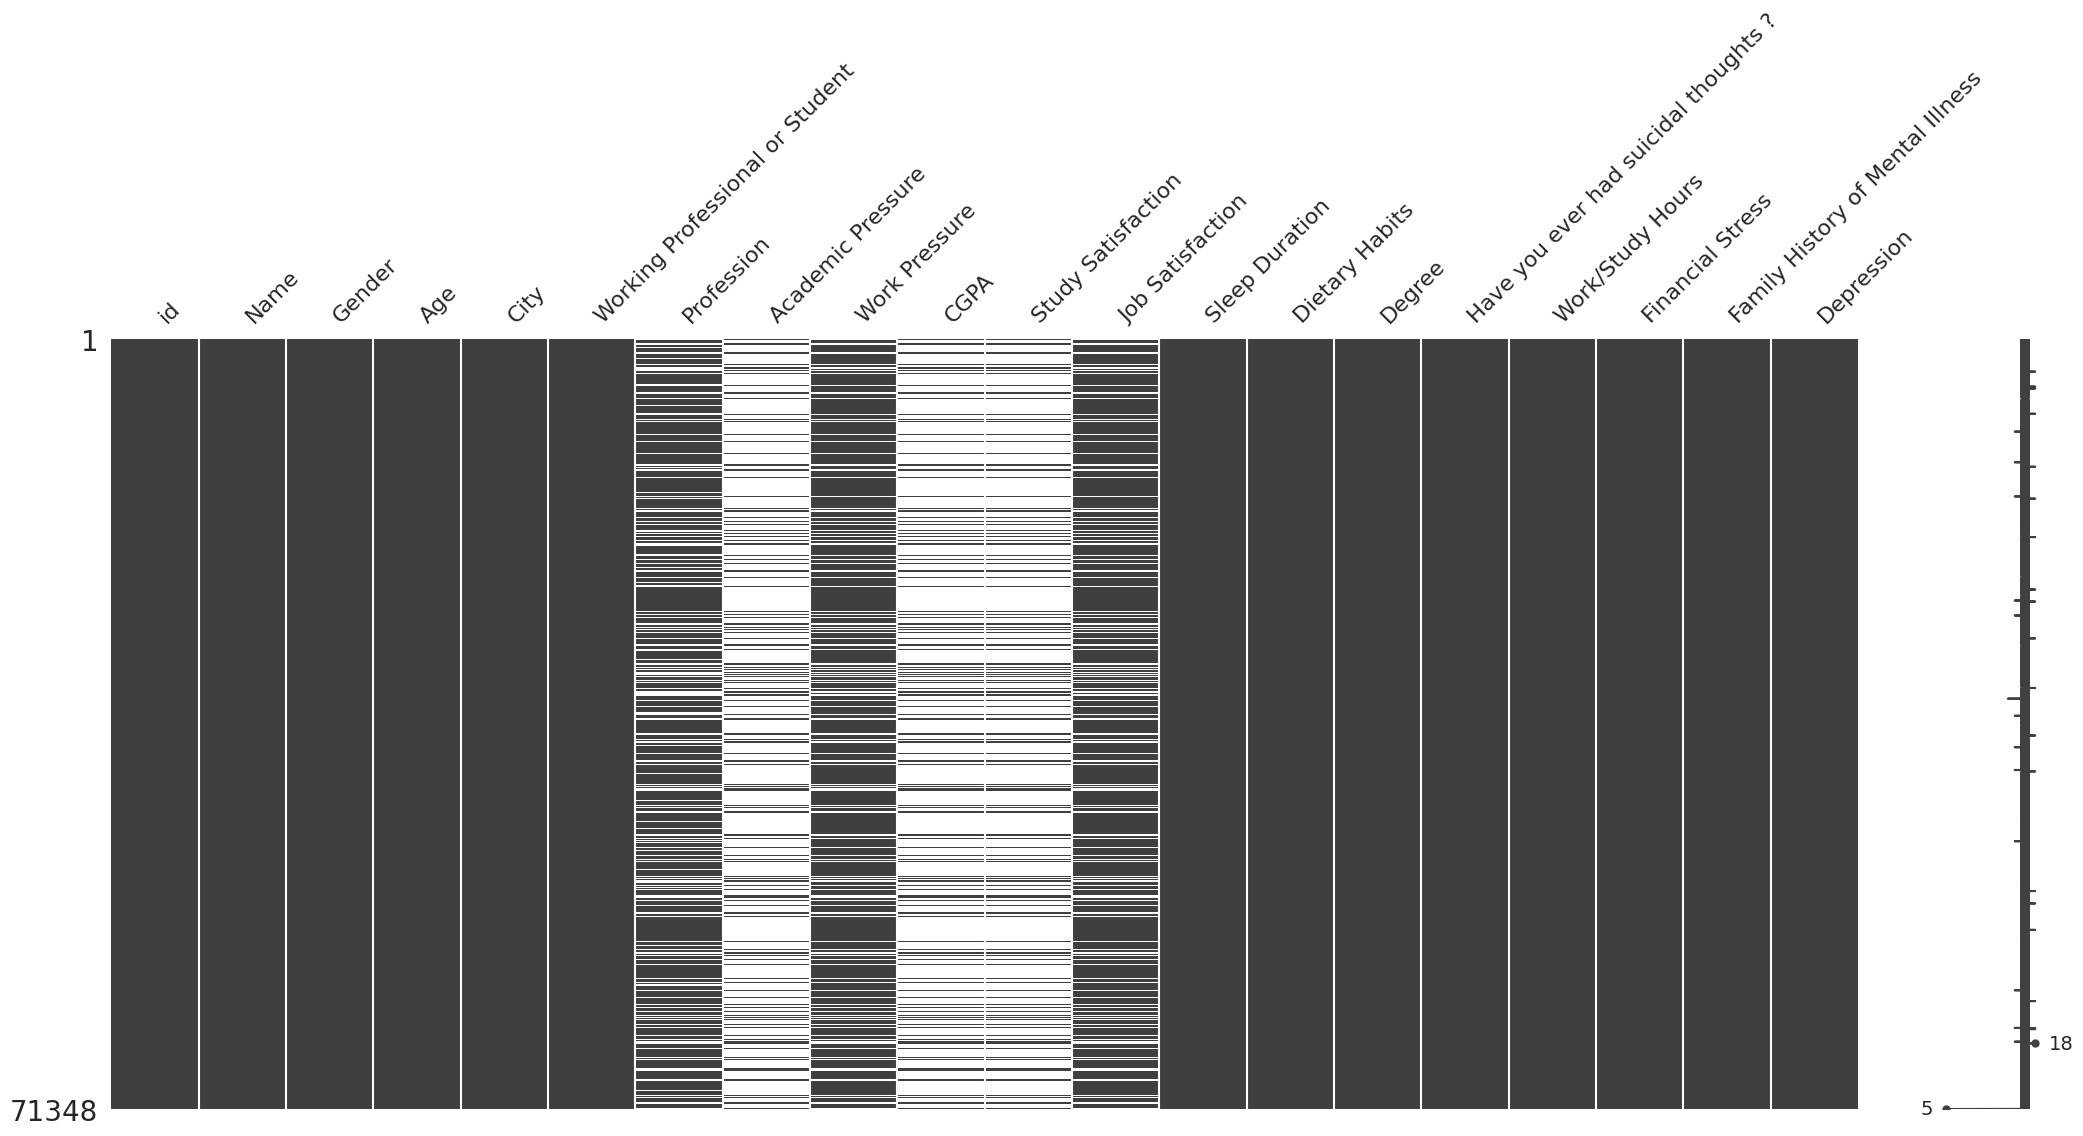

In [ ]:
# Visualize missing values
import missingno as msno
msno.matrix(df_train)

In [ ]:
df_train = df_train.drop(['id'], axis=1)
df_valid = df_valid.drop(['id'], axis=1)
df_test = df_test.drop(['id'], axis=1)

In [ ]:
# Define the target
target = 'Depression'

# Select categorical and numerical columns
categorical_columns = df_train.select_dtypes(include=['object']).columns
numerical_columns = df_train.select_dtypes(exclude=['object']).columns.drop(target)

print("Target:", target)
print("\nCategorical Columns:", categorical_columns.tolist())
print("\nNumerical Columns:", numerical_columns.tolist())

Target: Depression

Categorical Columns: ['Name', 'Gender', 'City', 'Working Professional or Student', 'Profession', 'Sleep Duration', 'Dietary Habits', 'Degree', 'Have you ever had suicidal thoughts ?', 'Family History of Mental Illness']

Numerical Columns: ['Age', 'Academic Pressure', 'Work Pressure', 'CGPA', 'Study Satisfaction', 'Job Satisfaction', 'Work/Study Hours', 'Financial Stress']


In [ ]:
df_train["Depression"].value_counts()

,count
Depression,
0.0,58393
1.0,12954


In [ ]:
# Number of unique values in categorical columns
for column in categorical_columns:
    unique_values = df_train[column].nunique()
    print(f"Column '{column}' has {unique_values} unique values.")

Column 'Name' has 323 unique values.
Column 'Gender' has 2 unique values.
Column 'City' has 66 unique values.
Column 'Working Professional or Student' has 2 unique values.
Column 'Profession' has 48 unique values.
Column 'Sleep Duration' has 23 unique values.
Column 'Dietary Habits' has 14 unique values.
Column 'Degree' has 84 unique values.
Column 'Have you ever had suicidal thoughts ?' has 2 unique values.
Column 'Family History of Mental Illness' has 2 unique values.


In [ ]:
# Unique value counts for each categorical column
for column in categorical_columns:
    value_counts = df_train[column].value_counts()
    print(f"\nValue counts for column '{column}':")
    print(value_counts)


Value counts for column 'Name':
Name
Rohan       1608
Aarav       1192
Rupak       1087
Anvi        1060
Aaradhya    1029
            ... 
Ayhan          1
Rietal         1
Shivna         1
Golkut         1
Prarav         1
Name: count, Length: 323, dtype: int64

Value counts for column 'Gender':
Gender
Male      39244
Female    32104
Name: count, dtype: int64

Value counts for column 'City':
City
Kalyan         3312
Patna          2991
Kolkata        2933
Ahmedabad      2931
Vasai-Virar    2897
               ... 
Vidhi             1
Mira              1
3.0               1
Nalini            1
Khushi            1
Name: count, Length: 66, dtype: int64

Value counts for column 'Working Professional or Student':
Working Professional or Student
Working Professional    57173
Student                 14174
Name: count, dtype: int64

Value counts for column 'Profession':
Profession
Teacher                   12545
Content Writer             4015
Architect                  2217
Consultant      

# Explatory Data Analysis

In [ ]:
sns.set(style="whitegrid", palette="Set2")

### Distribution of age, CGPA, Work/Study Hours

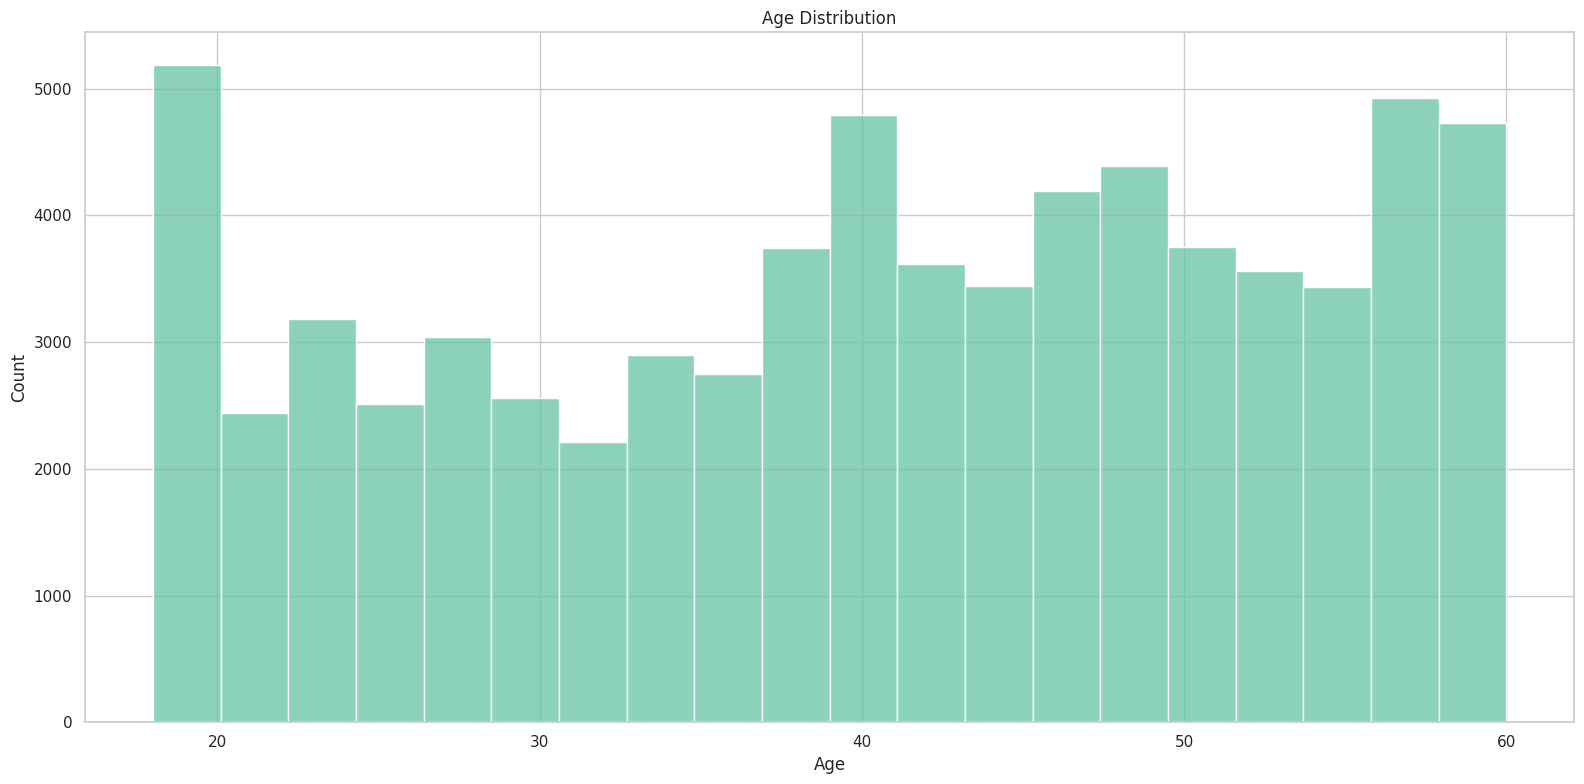

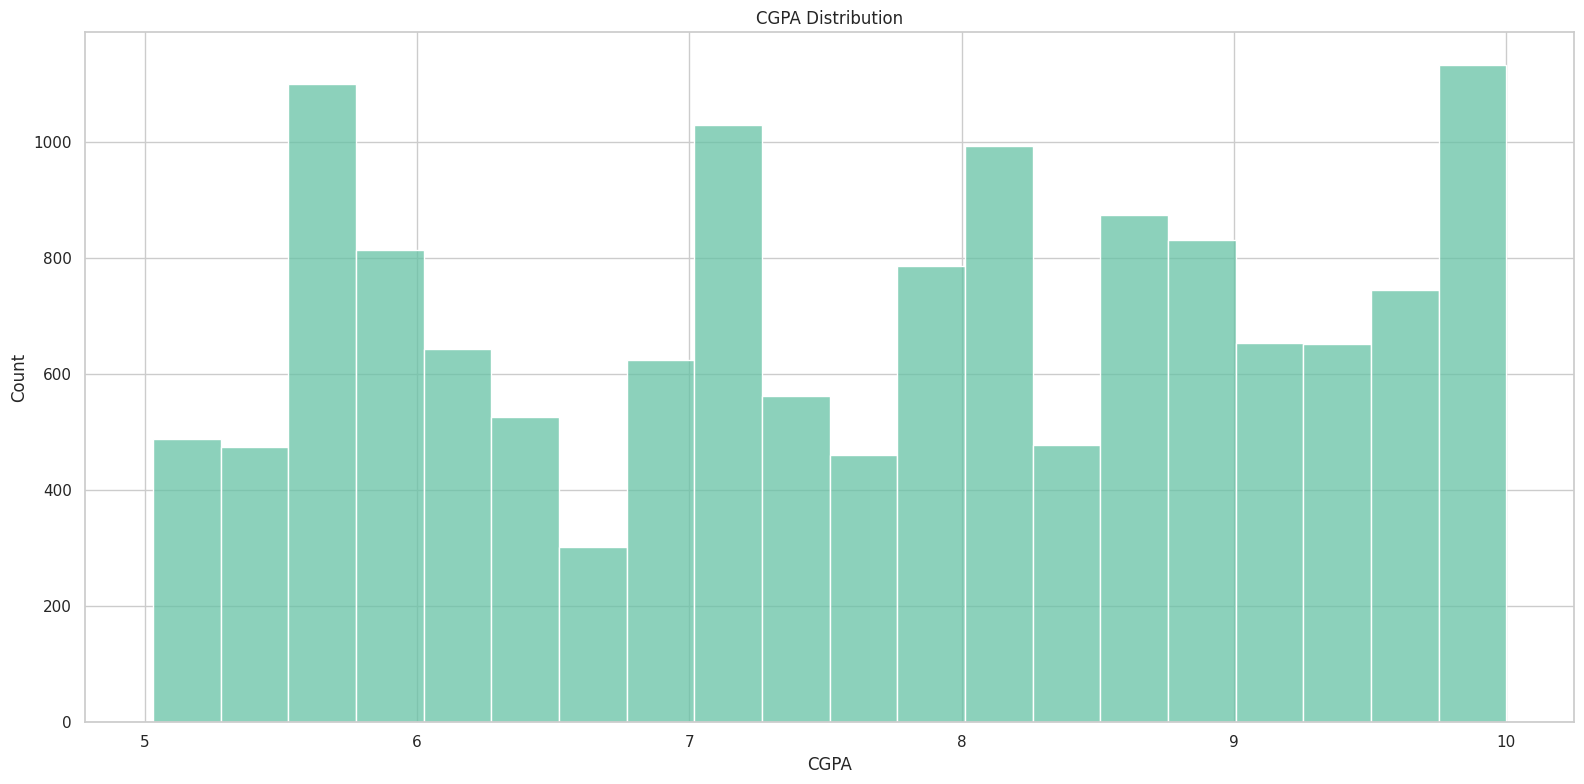

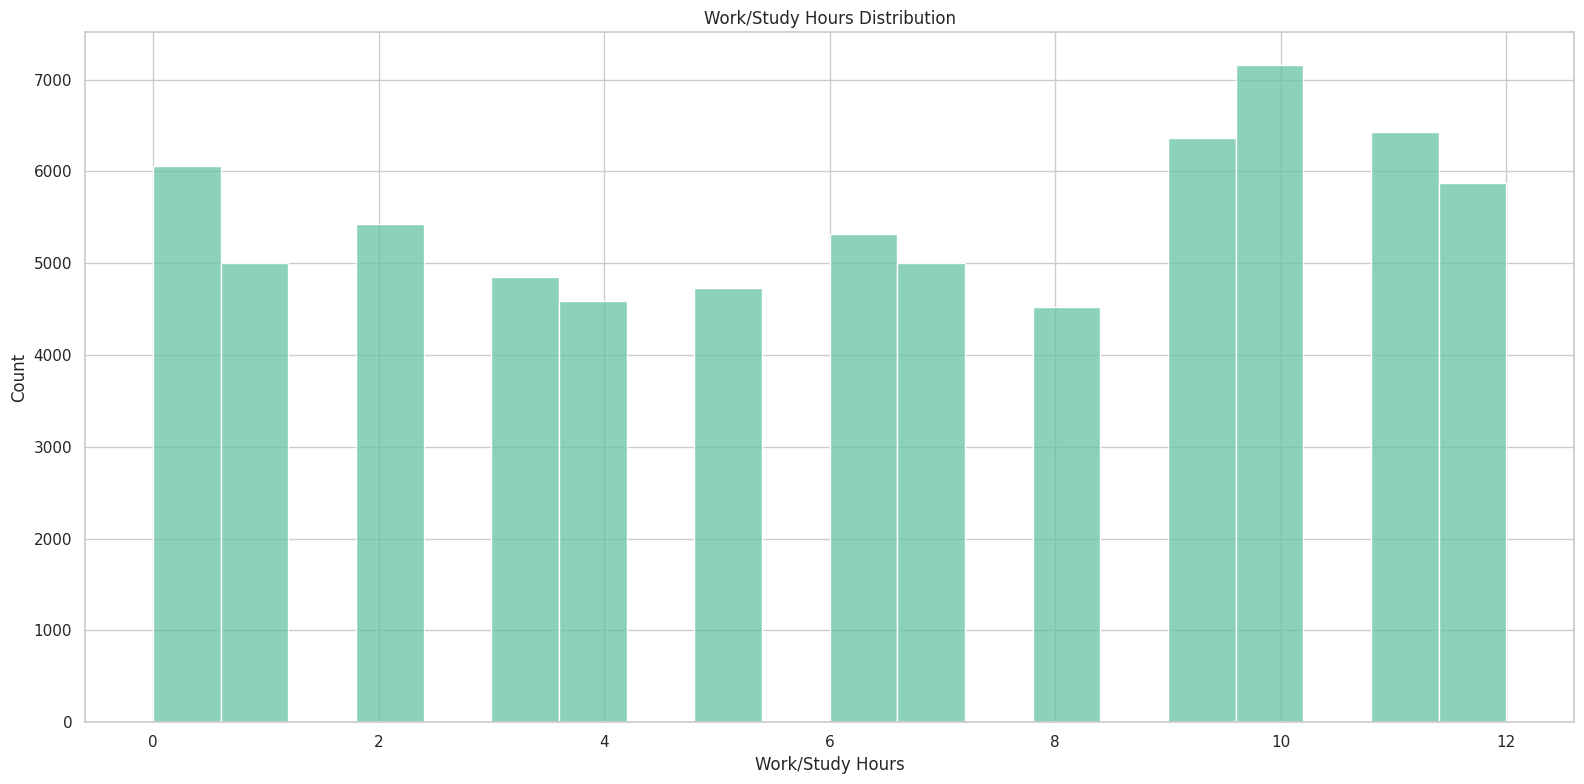

In [ ]:
# Distribution plot of age, CGPA, work/study hours
cols_to_plot_num = ['Age', 'CGPA', 'Work/Study Hours']
for column in cols_to_plot_num:
  plt.figure(figsize=(16, 8))
  sns.histplot(data=df_train, x=column, bins=20)
  plt.title(f'{column} Distribution')
  plt.tight_layout()
  plt.show()

### Distribution of gender, worker/student, suicidal thoughts, family histor, academic & work pressure, study & job satisfaction and financial stress

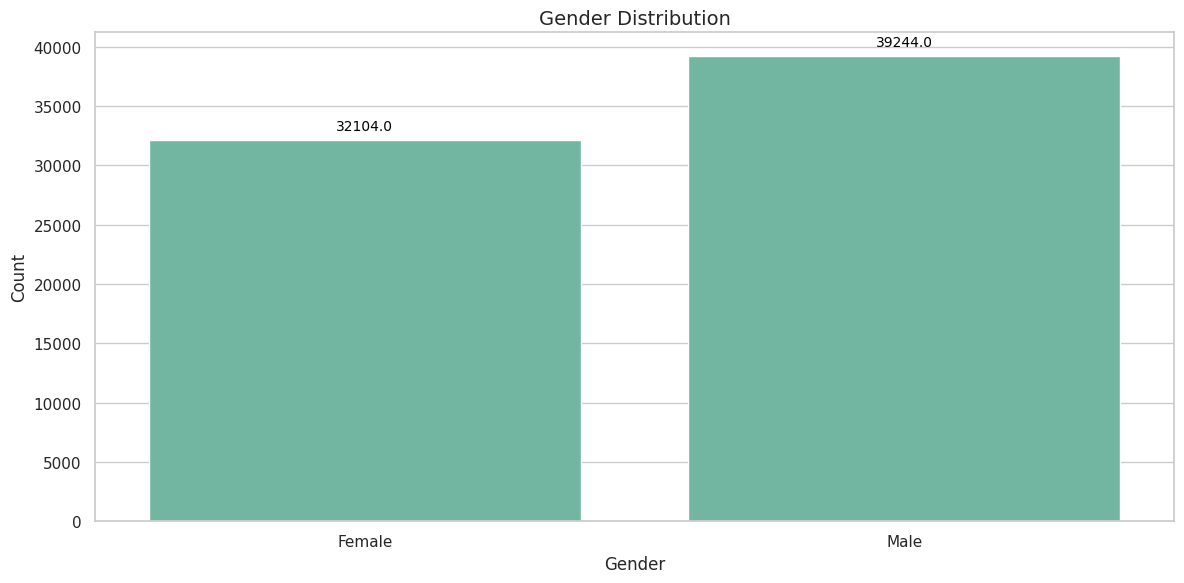

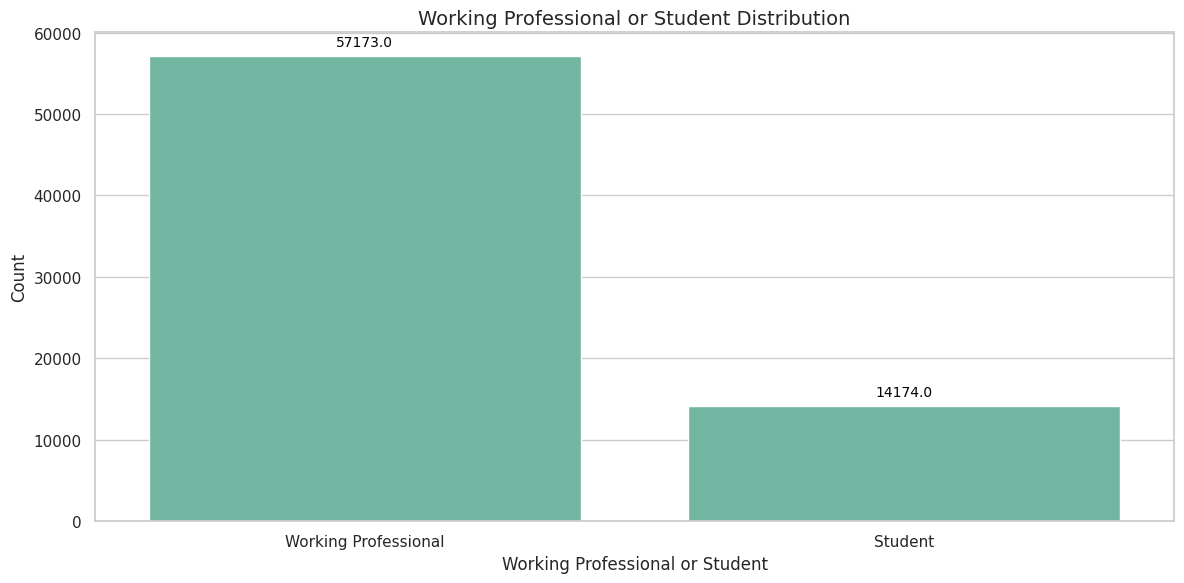

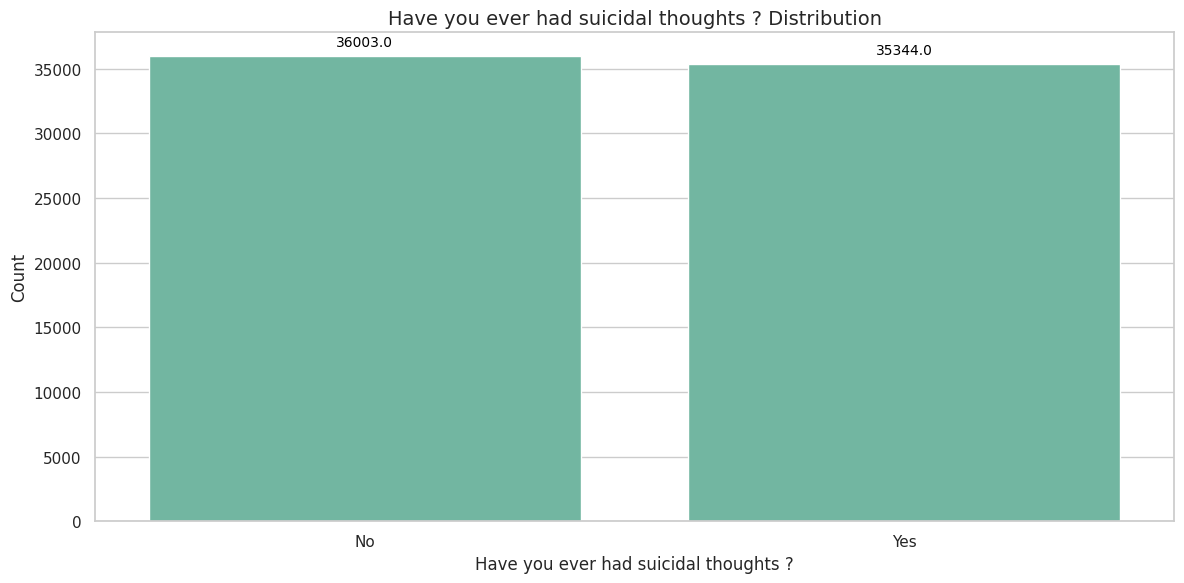

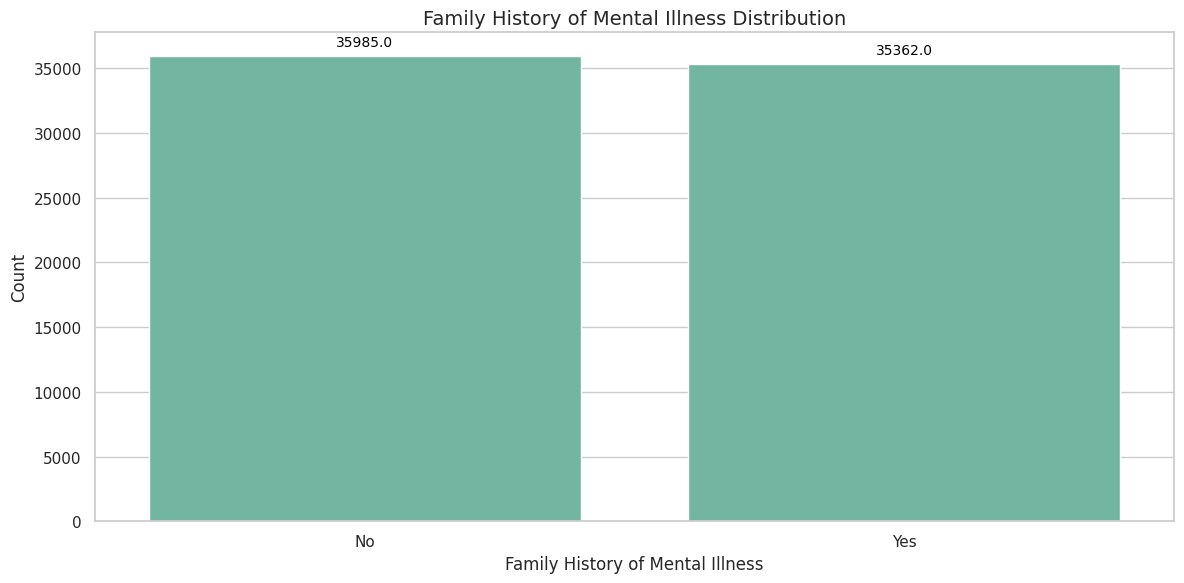

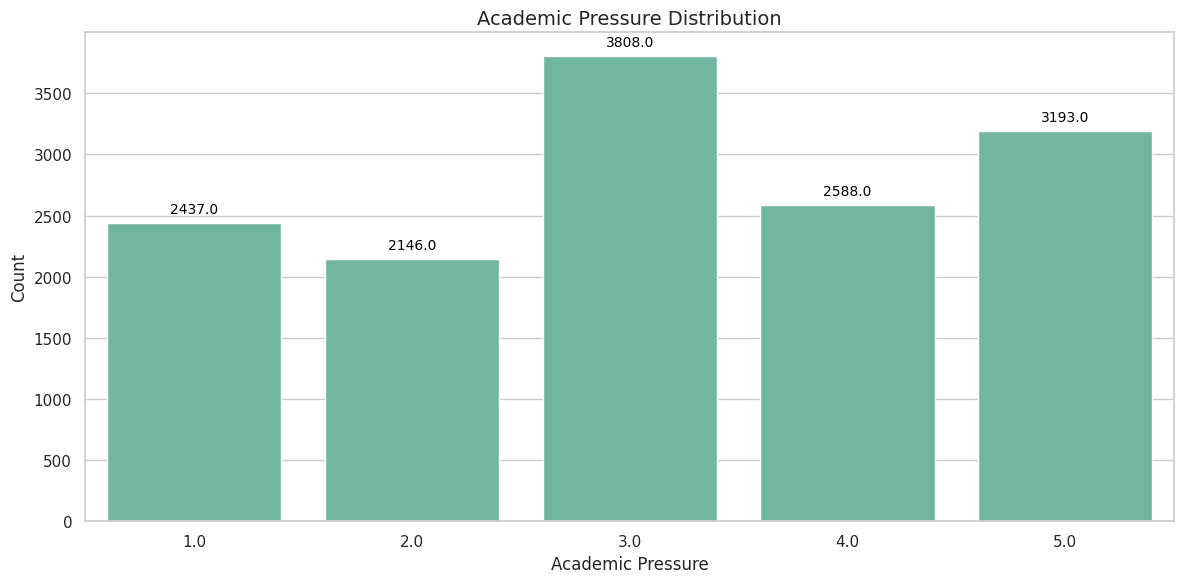

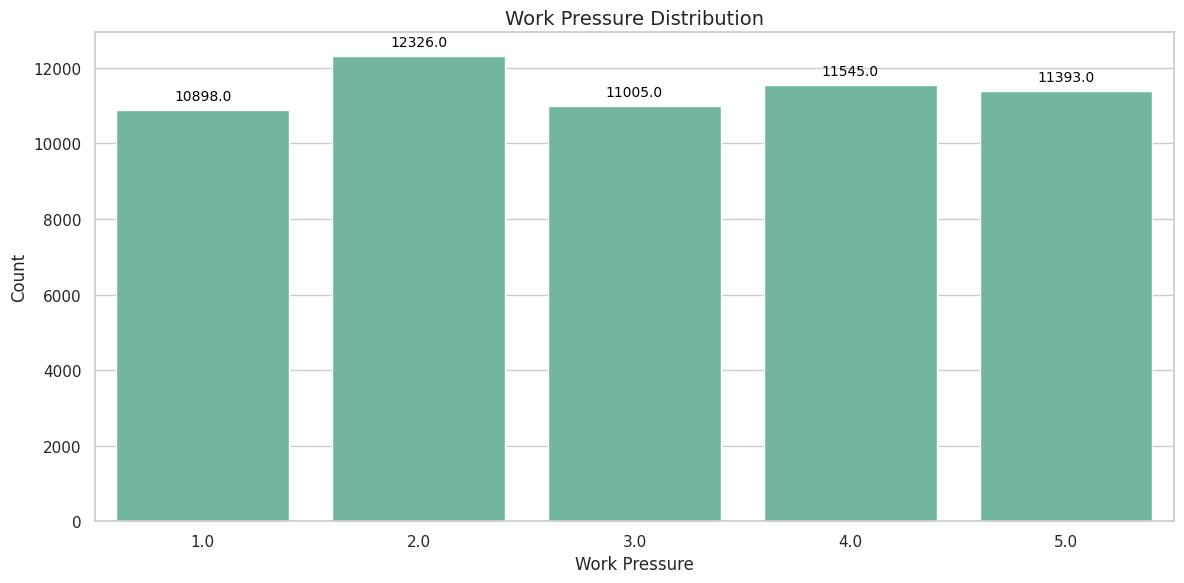

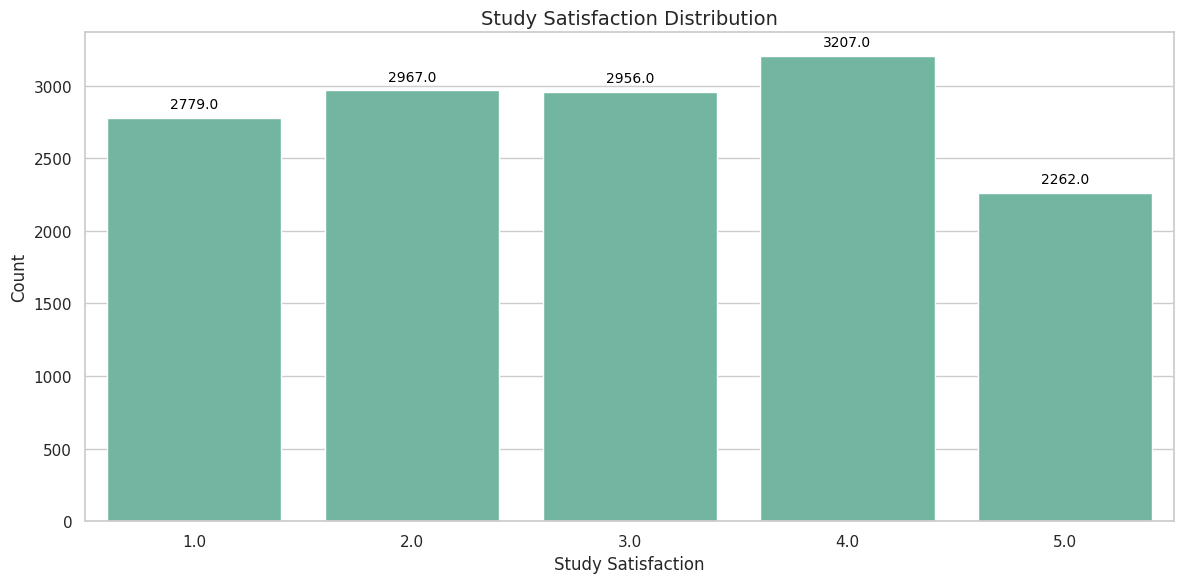

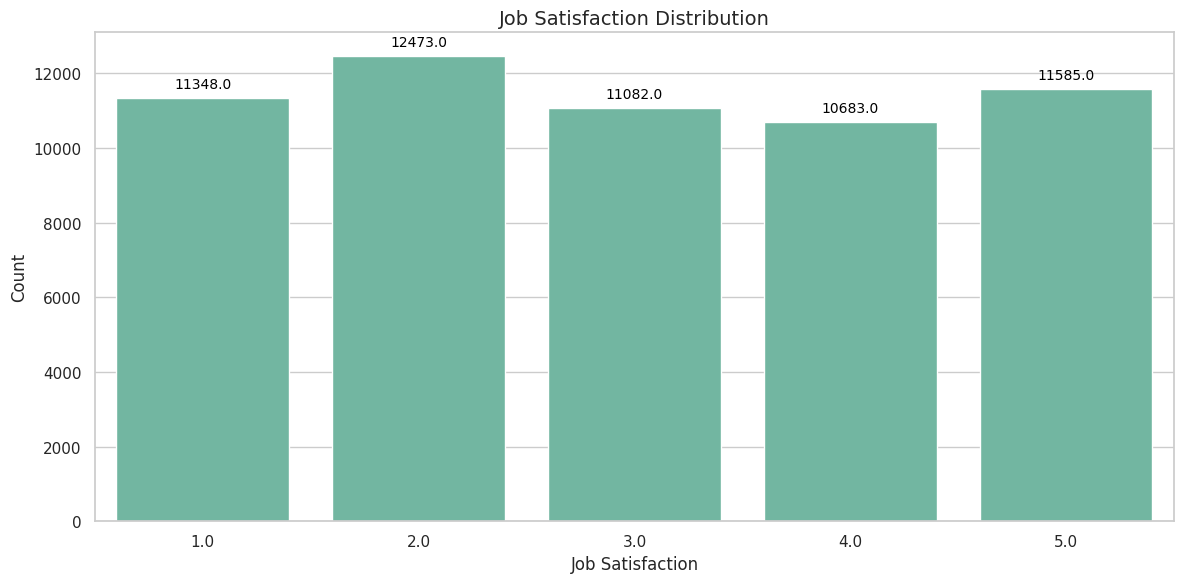

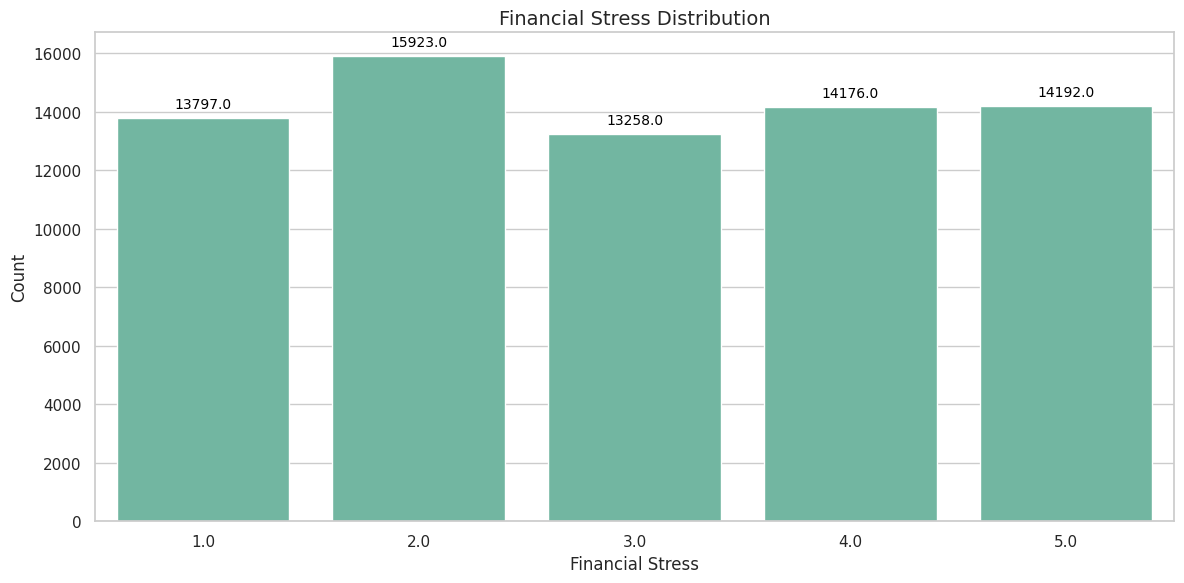

In [ ]:
cols_to_plot_cat = [
    'Gender',
    'Working Professional or Student',
    'Have you ever had suicidal thoughts ?',
    'Family History of Mental Illness',
    'Academic Pressure',
    'Work Pressure',
    'Study Satisfaction',
    'Job Satisfaction',
    'Financial Stress'
]

for column in cols_to_plot_cat:
    plt.figure(figsize=(12, 6))
    ax = sns.countplot(data=df_train, x=column)
    ax.set_title(f'{column} Distribution', fontsize=14)
    ax.set_ylabel("Count")

    for p in ax.patches:
        height = p.get_height()
        ax.annotate(f'{height}',
                    (p.get_x() + p.get_width() / 2., height),
                    ha='center', va='bottom',
                    fontsize=10, color='black',
                    xytext=(0, 5), textcoords='offset points')

    plt.tight_layout()
    plt.show()

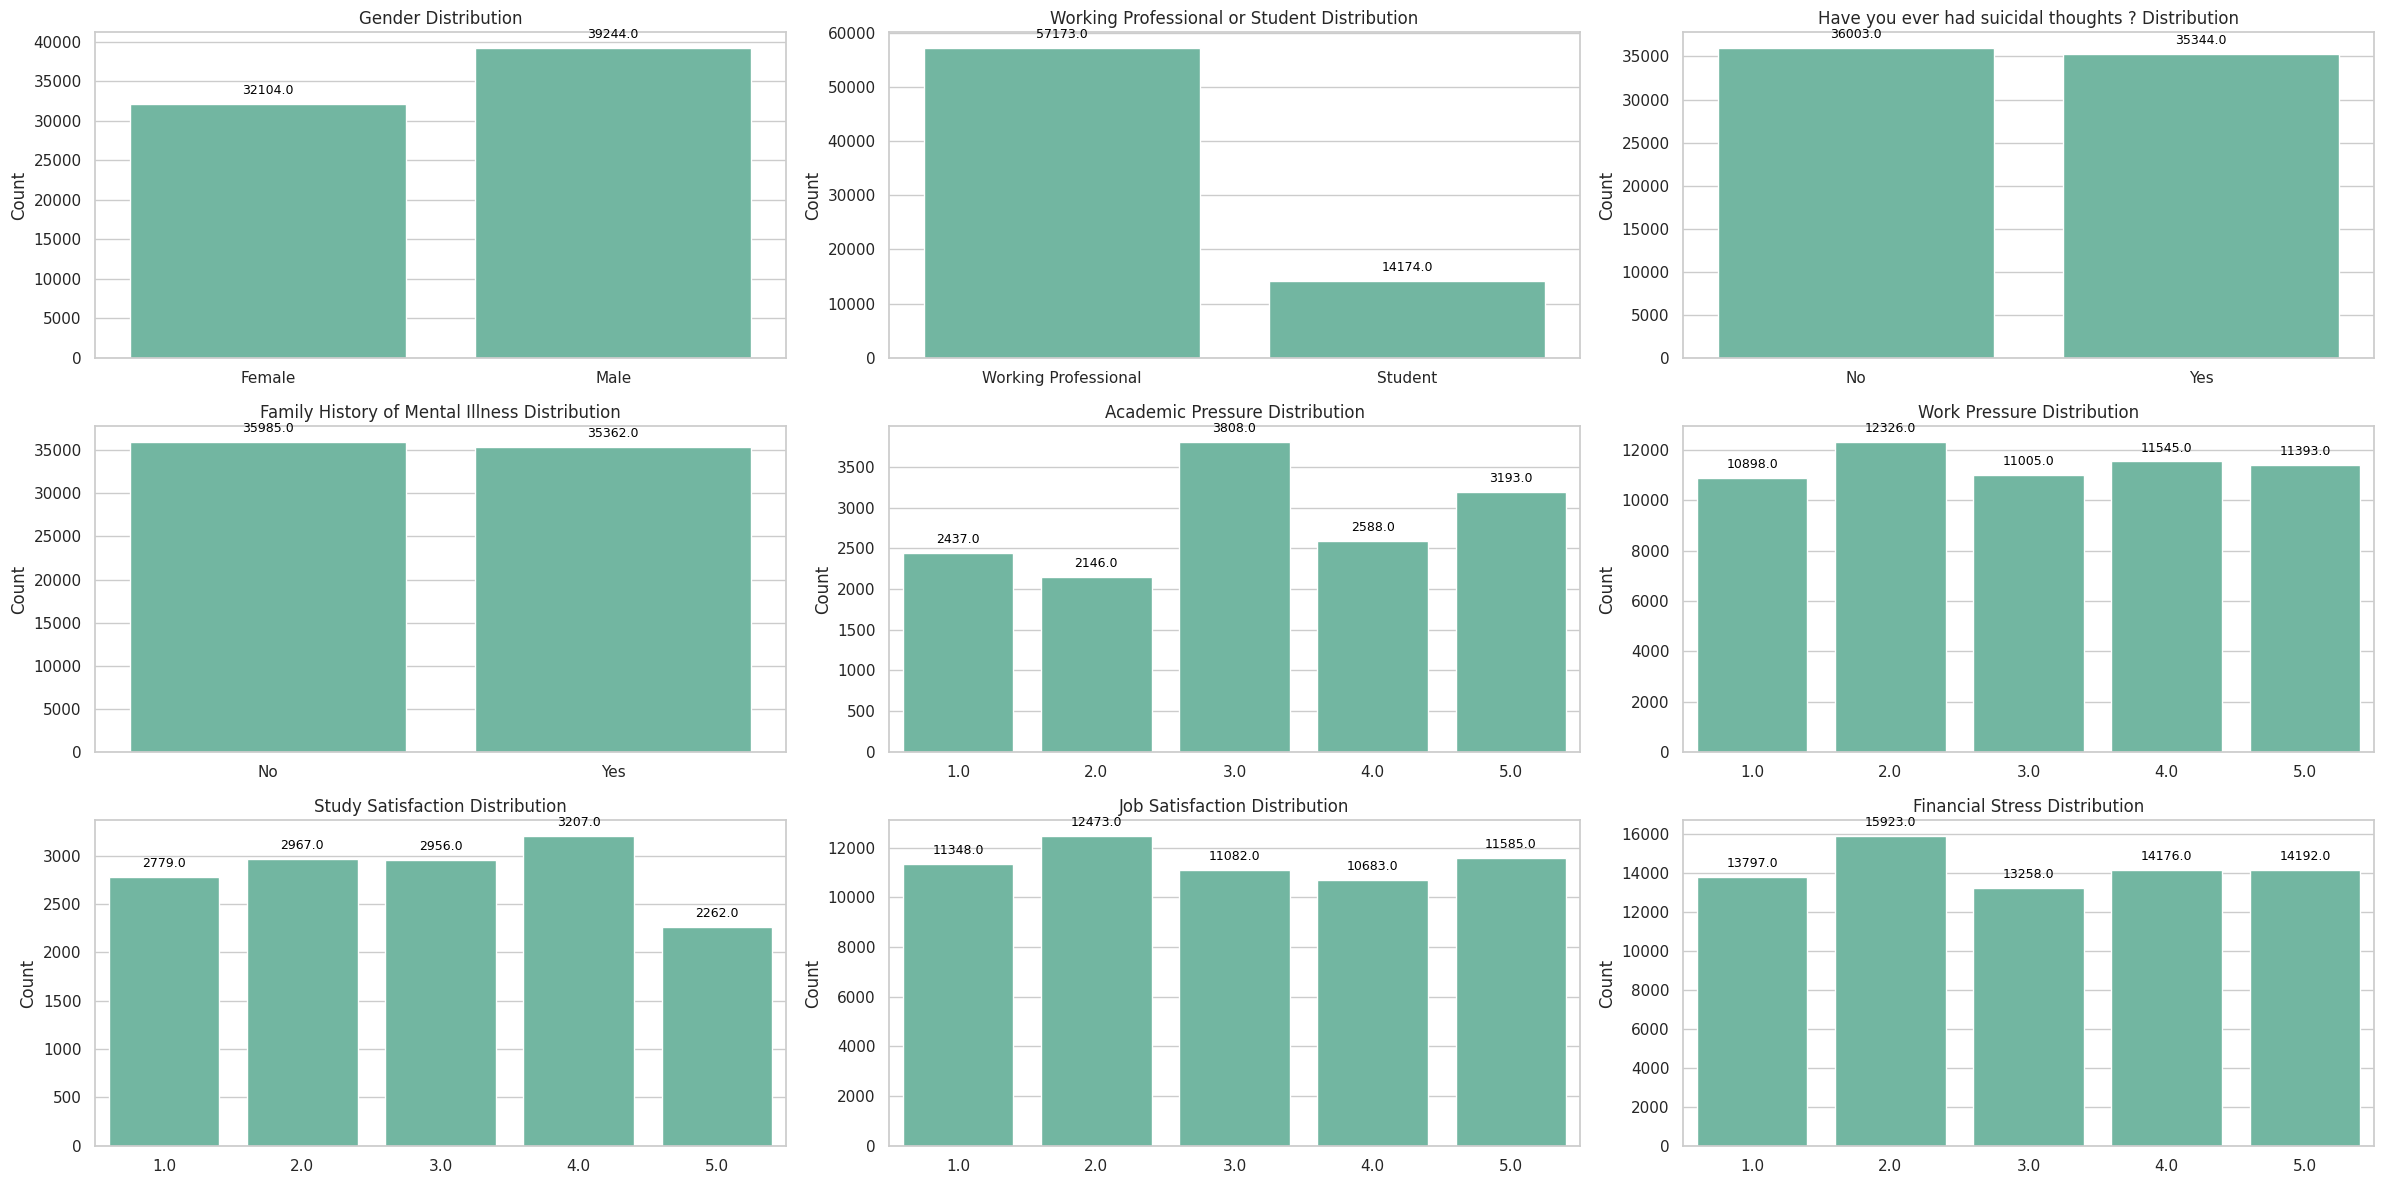

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

cols_to_plot_cat = [
    'Gender',
    'Working Professional or Student',
    'Have you ever had suicidal thoughts ?',
    'Family History of Mental Illness',
    'Academic Pressure',
    'Work Pressure',
    'Study Satisfaction',
    'Job Satisfaction',
    'Financial Stress'
]

n_cols = 3
n_rows = -(-len(cols_to_plot_cat) // n_cols)  # ceiling division

fig, axes = plt.subplots(n_rows, n_cols, figsize=(24, 12))
axes = axes.flatten()

for i, column in enumerate(cols_to_plot_cat):
    ax = axes[i]
    sns.countplot(data=df_train, x=column, ax=ax)
    ax.set_title(f'{column} Distribution', fontsize=12)
    ax.set_ylabel("Count")
    ax.set_xlabel("")

    for p in ax.patches:
        height = p.get_height()
        ax.annotate(f'{height}',
                    (p.get_x() + p.get_width() / 2., height),
                    ha='center', va='bottom',
                    fontsize=9, color='black',
                    xytext=(0, 5), textcoords='offset points')

# Boş kalan subplot’ları kaldır
for j in range(len(cols_to_plot_cat), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

### Depression distribution by gender

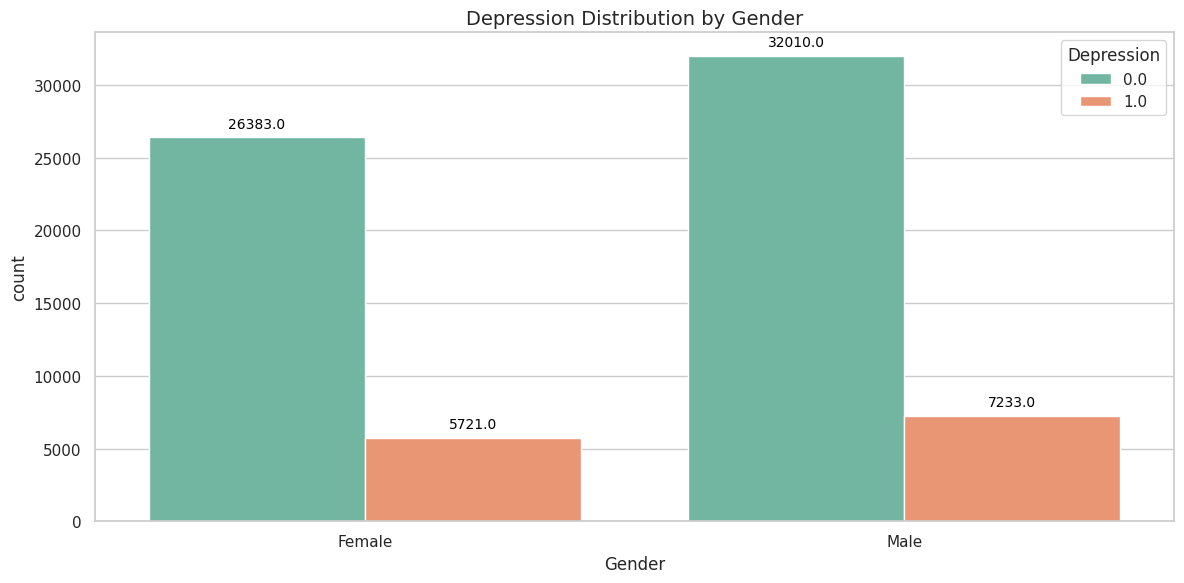

In [ ]:
#  Visualize "Depression" on the basis of "Gender"
plt.figure(figsize=(12, 6))
ax = sns.countplot(data=df_train, x='Gender', hue='Depression')
ax.set_title('Depression Distribution by Gender', fontsize=14)

for p in ax.patches:
    height = p.get_height()
    if height > 0:
        ax.annotate(f'{height}',
                    (p.get_x() + p.get_width() / 2., height),
                    ha='center', va='bottom',
                    fontsize=10, color='black',
                    xytext=(0, 5), textcoords='offset points')

plt.tight_layout()
plt.show()

### Depression rate by gender

In [ ]:
# Average depression score by gender
gender_depression_mean = df_train.groupby('Gender')['Depression'].mean() * 100
gender_depression_mean

,Depression
Gender,
Female,17.820209
Male,18.431313


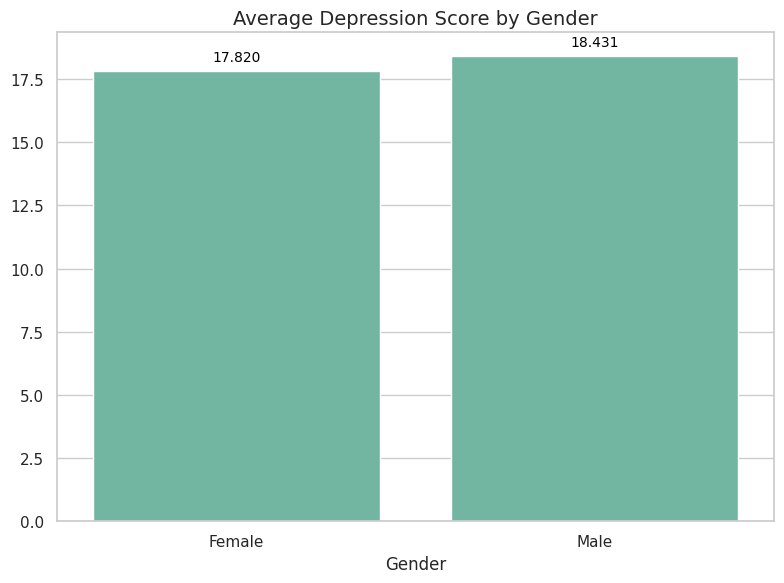

In [ ]:
# Visualize avg. depression score by gender with .3f values
plt.figure(figsize=(8, 6))
ax = sns.barplot(x=gender_depression_mean.index, y=gender_depression_mean.values)
ax.set_title('Average Depression Score by Gender', fontsize=14)

for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height:.3f}',
                (p.get_x() + p.get_width() / 2., height),
                ha='center', va='bottom',
                fontsize=10, color='black',
                xytext=(0, 5), textcoords='offset points')
plt.tight_layout()
plt.show()

### Suicidal thoughts by gender

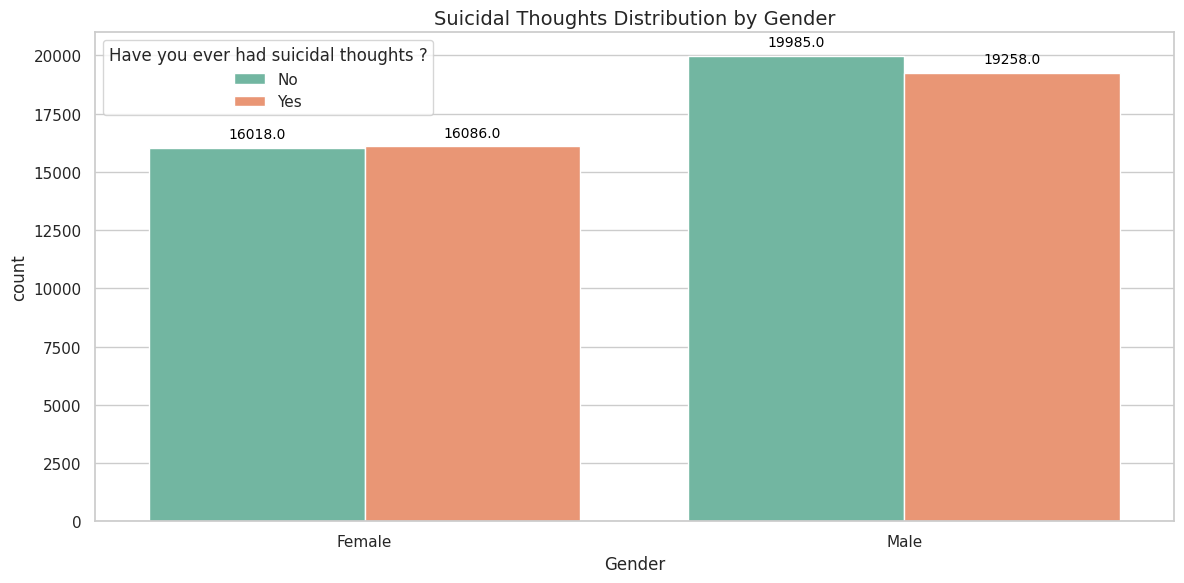

In [ ]:
# Visualize "Suicidal Thoughts" by "Gender"
plt.figure(figsize=(12, 6))
ax = sns.countplot(data=df_train, x='Gender', hue='Have you ever had suicidal thoughts ?')
ax.set_title('Suicidal Thoughts Distribution by Gender', fontsize=14)

for p in ax.patches:
    height = p.get_height()
    if height > 0:
        ax.annotate(f'{height}',
                    (p.get_x() + p.get_width() / 2., height),
                    ha='center', va='bottom',
                    fontsize=10, color='black',
                    xytext=(0, 5), textcoords='offset points')

plt.tight_layout()
plt.show()

### Suicidal thoughts rate by gender

In [ ]:
# Let's see the suicidal thoughts rate by gender
gender_suicidal_rate = df_train.groupby('Gender')['Have you ever had suicidal thoughts ?'].value_counts(normalize=True)
gender_suicidal_rate

Gender  Have you ever had suicidal thoughts ?
Female  Yes                                      0.501059
        No                                       0.498941
Male    No                                       0.509263
        Yes                                      0.490737
Name: proportion, dtype: float64

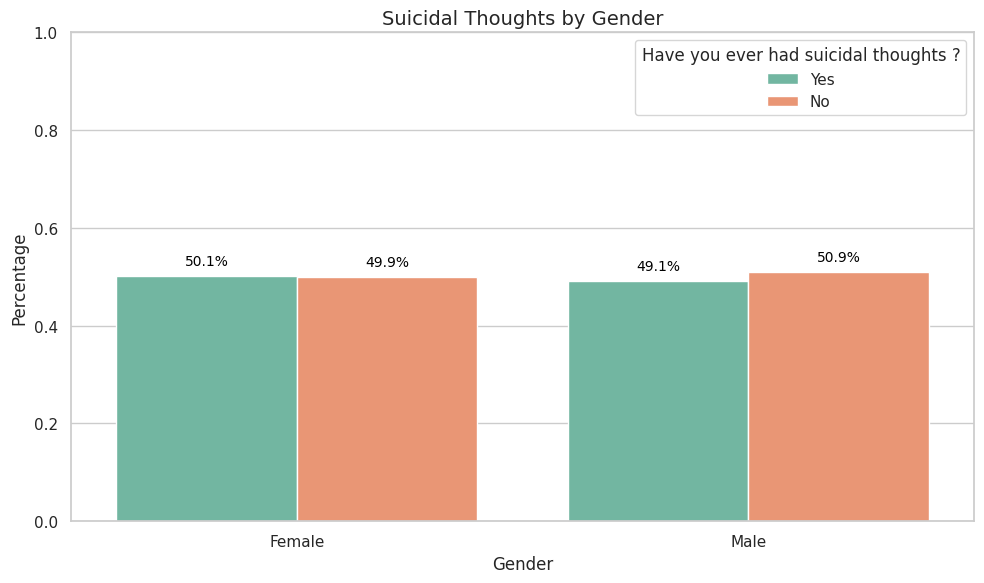

In [ ]:
gender_suicidal_rate = gender_suicidal_rate.rename('Percentage').reset_index()

plt.figure(figsize=(10, 6))
ax = sns.barplot(
    data=gender_suicidal_rate,
    x='Gender',
    y='Percentage',
    hue='Have you ever had suicidal thoughts ?',
)

for p in ax.patches:
    height = p.get_height()
    if height > 0.01:
        ax.annotate(f'{height * 100:.1f}%',
                    (p.get_x() + p.get_width() / 2., height),
                    ha='center', va='bottom',
                    fontsize=10, color='black',
                    xytext=(0, 6), textcoords='offset points')

plt.title('Suicidal Thoughts by Gender', fontsize=14)
plt.ylabel('Percentage')
plt.xlabel('Gender')
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

### Distribution of age by depression

Text(0.5, 1.0, 'Age Distribution by Depression')

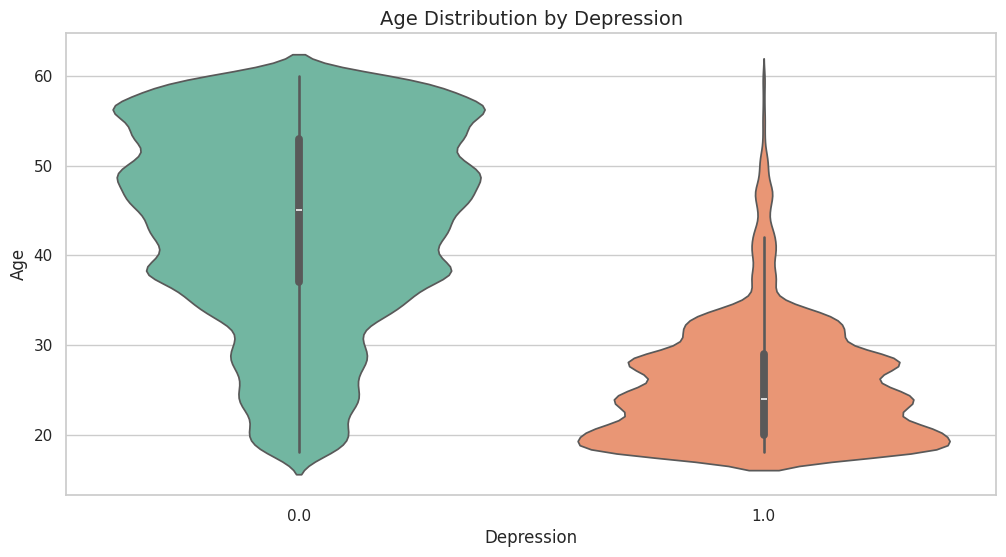

In [ ]:
# Distribution of age by depression on violin plot
plt.figure(figsize=(12, 6))
ax = sns.violinplot(data=df_train, x='Depression', y='Age', palette='Set2')
ax.set_title('Age Distribution by Depression', fontsize=14)

### Distribution of work/study hours by depression

Text(0.5, 1.0, 'Work/Study Hours Distribution by Depression')

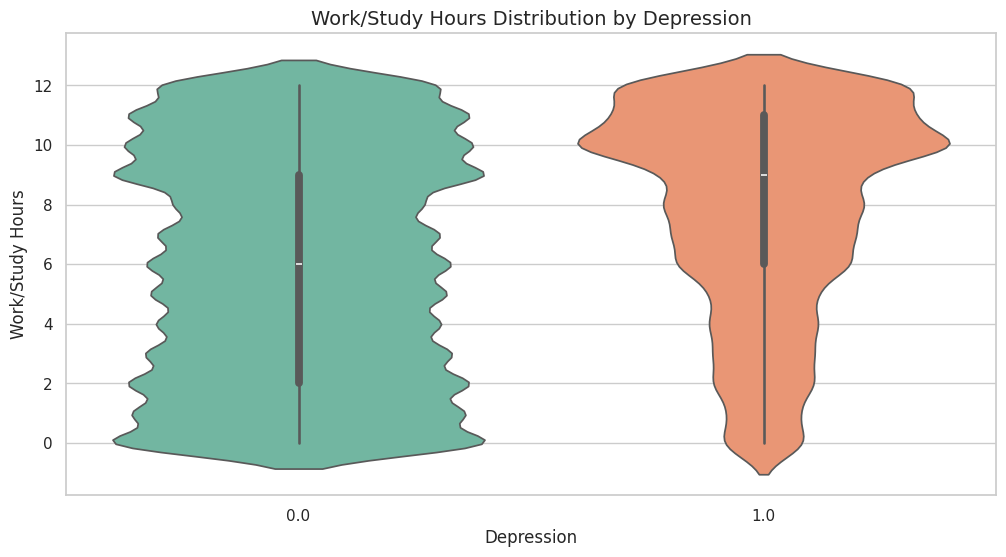

In [ ]:
# Distribution of work/study hours by depression on violin plot
plt.figure(figsize=(12, 6))
ax = sns.violinplot(data=df_train, x='Depression', y='Work/Study Hours', palette='Set2')
ax.set_title('Work/Study Hours Distribution by Depression', fontsize=14)

### Working status distribution by gender

Text(0, 0.5, '')

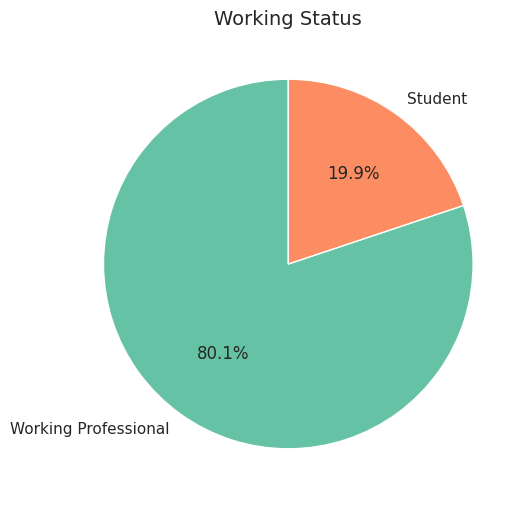

In [ ]:
# Working Professional or Student pie chart distribution
plt.figure(figsize=(12, 6))
ax = df_train['Working Professional or Student'].value_counts().plot(kind='pie', autopct='%1.1f%%', startangle=90)
ax.set_title('Working Status', fontsize=14)
plt.ylabel('')

Working status distribution by depression

Text(0, 0.5, 'Count')

<Figure size 1200x600 with 0 Axes>

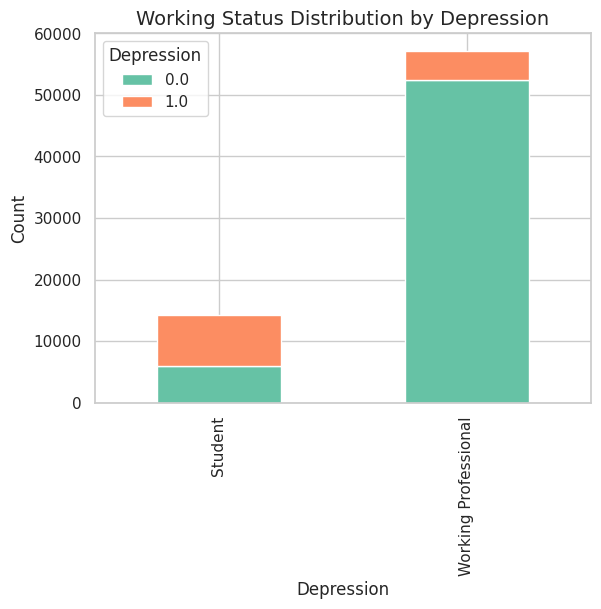

In [ ]:
# Working status distribution by depression on stacked bar plot
plt.figure(figsize=(12, 6))
ax = df_train.groupby(['Working Professional or Student', 'Depression']).size().unstack().plot(kind='bar', stacked=True)
ax.set_title('Working Status Distribution by Depression', fontsize=14)
ax.set_xlabel('Depression')
ax.set_ylabel('Count')

### Academic pressure distribution by depression

Text(0, 0.5, 'Count')

<Figure size 1200x600 with 0 Axes>

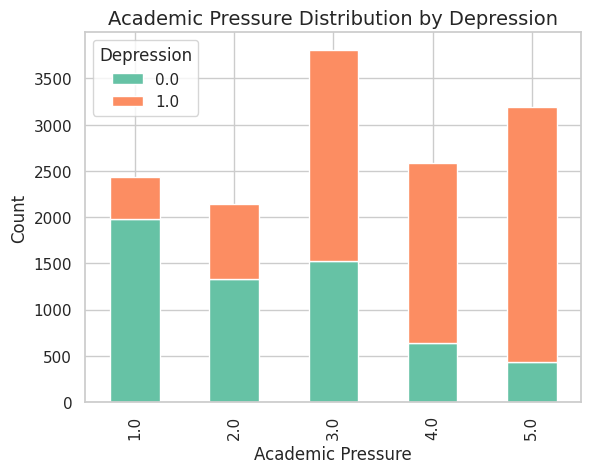

In [ ]:
# Academic pressure distribution by depression on stacked bar plot
plt.figure(figsize=(12, 6))
ax = df_train.groupby(['Academic Pressure', 'Depression']).size().unstack().plot(kind='bar', stacked=True)
ax.set_title('Academic Pressure Distribution by Depression', fontsize=14)
ax.set_xlabel('Academic Pressure')
ax.set_ylabel('Count')

###Work pressure distribution by depression

Text(0, 0.5, 'Count')

<Figure size 1200x600 with 0 Axes>

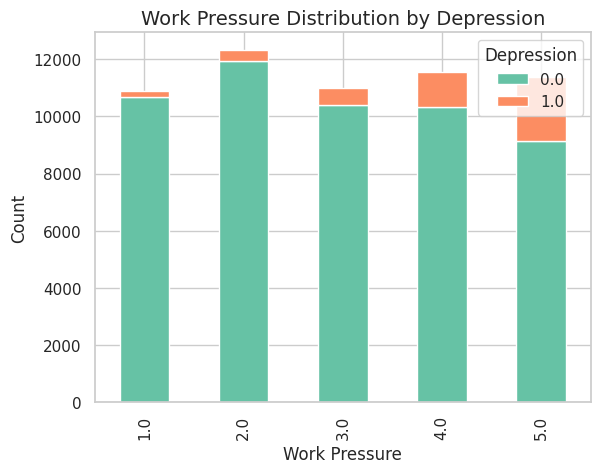

In [ ]:
# Work pressure distribution by depression on stacked bar plot
plt.figure(figsize=(12, 6))
ax = df_train.groupby(['Work Pressure', 'Depression']).size().unstack().plot(kind='bar', stacked=True)
ax.set_title('Work Pressure Distribution by Depression', fontsize=14)
ax.set_xlabel('Work Pressure')
ax.set_ylabel('Count')

### Study satistfaction distribution by depression

Text(0, 0.5, 'Count')

<Figure size 1200x600 with 0 Axes>

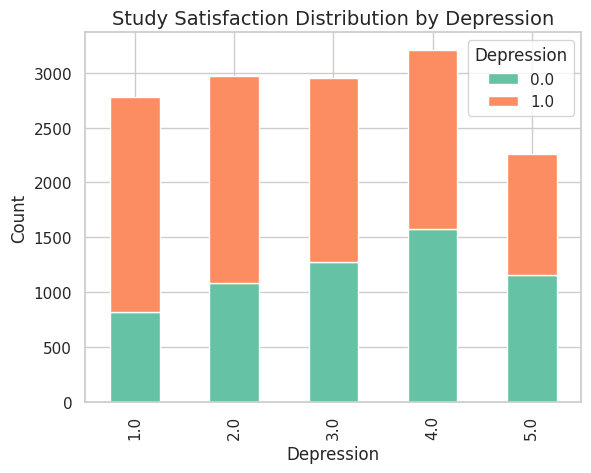

In [ ]:
# Study satisfaction distribution by depression on stacked bar plot
plt.figure(figsize=(12, 6))
ax = df_train.groupby(['Study Satisfaction', 'Depression']).size().unstack().plot(kind='bar', stacked=True)
ax.set_title('Study Satisfaction Distribution by Depression', fontsize=14)
ax.set_xlabel('Study Satisfaction')
ax.set_ylabel('Count')

### Job satisfaction distribution by depression

Text(0, 0.5, 'Count')

<Figure size 1200x600 with 0 Axes>

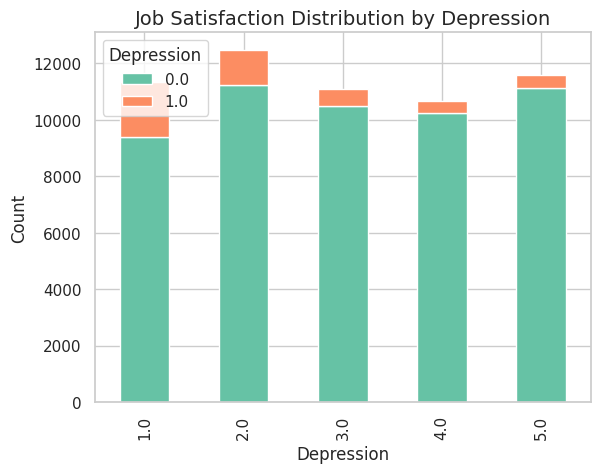

In [ ]:
# Job satisfaction distribution by depression on stacked bar plot
plt.figure(figsize=(12, 6))
ax = df_train.groupby(['Job Satisfaction', 'Depression']).size().unstack().plot(kind='bar', stacked=True)
ax.set_title('Job Satisfaction Distribution by Depression', fontsize=14)
ax.set_xlabel('Depression')
ax.set_ylabel('Count')

### Financial stress distribution by depression

Text(0, 0.5, 'Count')

<Figure size 1200x600 with 0 Axes>

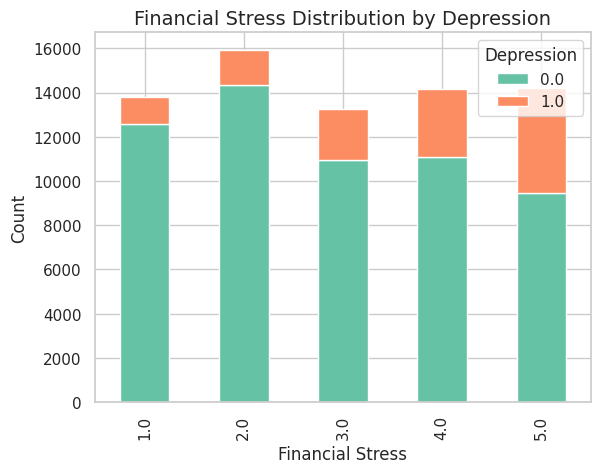

In [ ]:
# Financial stress distribution by depression on stacked bar plot
plt.figure(figsize=(12, 6))
ax = df_train.groupby(['Financial Stress', 'Depression']).size().unstack().plot(kind='bar', stacked=True)
ax.set_title('Financial Stress Distribution by Depression', fontsize=14)
ax.set_xlabel('Financial Stress')
ax.set_ylabel('Count')

###Map of professions

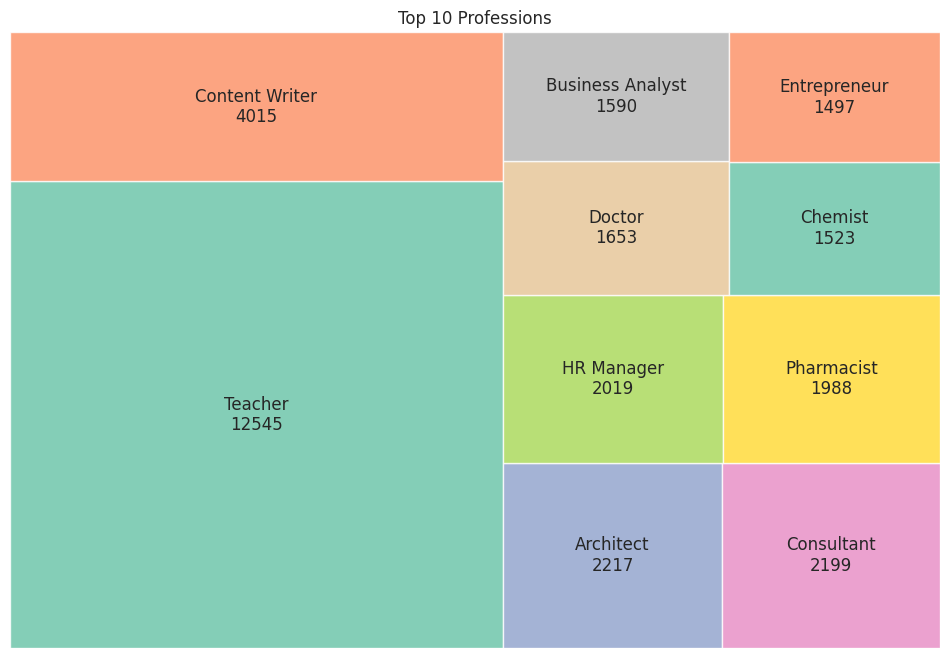

In [ ]:
# Treemap of professions
!pip install squarify
import squarify

profession_counts = df_train['Profession'].value_counts().head(10)
sizes = profession_counts.values
labels = [f"{p}\n{c}" for p, c in zip(profession_counts.index, sizes)]

palette = sns.color_palette("Set2", 10).as_hex()

plt.figure(figsize=(12,8))
squarify.plot(sizes=sizes, label=labels, color=palette, alpha=0.8)
plt.title("Top 10 Professions")
plt.axis('off')
plt.show()

### Depression percentage by profession

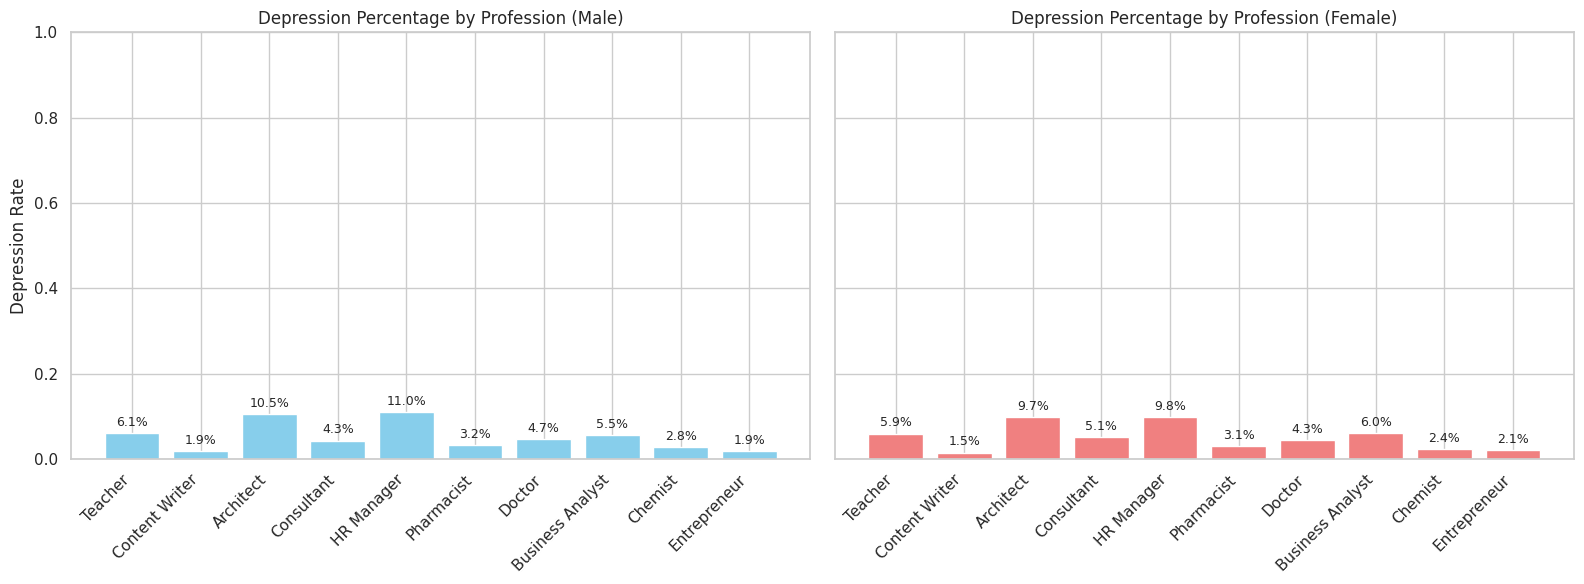

In [ ]:
total_counts = df_train.groupby(['Profession', 'Gender']).size().unstack(fill_value=0)
depressed_counts = df_train[df_train['Depression'] == 1].groupby(['Profession', 'Gender']).size().unstack(fill_value=0)
depression_rate = depressed_counts / total_counts
top10_professions = df_train['Profession'].value_counts().nlargest(10).index
depression_rate_top10 = depression_rate.loc[top10_professions]

professions = top10_professions.tolist()
male_rates = depression_rate_top10['Male'] if 'Male' in depression_rate_top10.columns else np.zeros(len(professions))
female_rates = depression_rate_top10['Female'] if 'Female' in depression_rate_top10.columns else np.zeros(len(professions))

fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

# Male
bars_male = axes[0].bar(professions, male_rates, color='skyblue')
axes[0].set_title('Depression Percentage by Profession (Male)')
axes[0].set_xticklabels(professions, rotation=45, ha='right')
axes[0].set_ylabel('Depression Rate')
axes[0].set_ylim(0, 1)

for bar in bars_male:
    height = bar.get_height()
    axes[0].annotate(f'{height*100:.1f}%',
                     xy=(bar.get_x() + bar.get_width() / 2, height),
                     xytext=(0, 3),
                     textcoords="offset points",
                     ha='center', va='bottom', fontsize=9)

# Female
bars_female = axes[1].bar(professions, female_rates, color='lightcoral')
axes[1].set_title('Depression Percentage by Profession (Female)')
axes[1].set_xticklabels(professions, rotation=45, ha='right')
axes[1].set_ylim(0, 1)

for bar in bars_female:
    height = bar.get_height()
    axes[1].annotate(f'{height*100:.1f}%',
                     xy=(bar.get_x() + bar.get_width() / 2, height),
                     xytext=(0, 3),
                     textcoords="offset points",
                     ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()


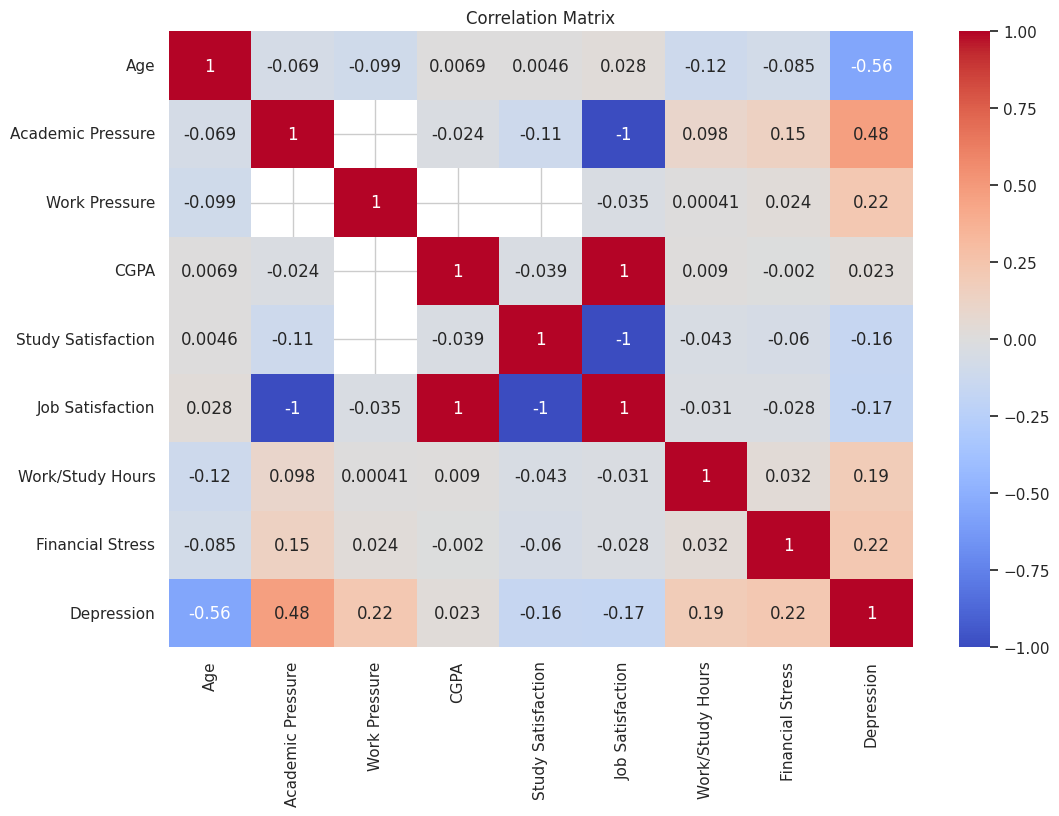

In [ ]:
# Correlataion Matrix
corr_matrix = df_train.corr(numeric_only=True)
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

# Data Cleaning

In [ ]:
# Let's concat train and valid set for easier data preprocessing
df = pd.concat([df_train, df_valid], axis=0)
df.head()
print(f"There are {df.shape[1]} columns and {df.shape[0]} rows." )

There are 19 columns and 99488 rows.


In [ ]:
# Some of the column names are too long
df = df_train.rename(
    columns={
        "Have you ever had suicidal thoughts ?": "Suicidal Thoughts",
        "Family History of Mental Illness": "Family History",
    }
)
df.columns

Index(['Name', 'Gender', 'Age', 'City', 'Working Professional or Student',
       'Profession', 'Academic Pressure', 'Work Pressure', 'CGPA',
       'Study Satisfaction', 'Job Satisfaction', 'Sleep Duration',
       'Dietary Habits', 'Degree', 'Suicidal Thoughts', 'Work/Study Hours',
       'Financial Stress', 'Family History', 'Depression'],
      dtype='object')

In [ ]:
# Examine the "Profession" column
df["Profession"].value_counts()

,count
Profession,
Teacher,12545
Content Writer,4015
Architect,2217
Consultant,2199
HR Manager,2019
Pharmacist,1988
Doctor,1653
Business Analyst,1590
Chemist,1523


There is already "Student" value in "Profession" column. So, Let's move "Student" values in "Working Professional or Student" column to the "Profession" column.

In [ ]:
df.loc[df["Working Professional or Student"] == "Student", "Profession"] = "Student"
df["Profession"].value_counts()

,count
Profession,
Student,14177
Teacher,12543
Content Writer,4014
Architect,2210
Consultant,2199
HR Manager,2019
Pharmacist,1988
Doctor,1652
Business Analyst,1590


In [ ]:
# Examine the "Academic Pressure" for the "Working Professional or Student" column
df.groupby(['Academic Pressure'])['Working Professional or Student'].value_counts()

Academic Pressure  Working Professional or Student
1.0                Student                            2437
2.0                Student                            2146
3.0                Student                            3807
                   Working Professional                  1
4.0                Student                            2586
                   Working Professional                  2
5.0                Student                            3193
Name: count, dtype: int64

In [ ]:
# Examine the "Work Pressure" for the "Working Professional or Student" column
df.groupby(['Work Pressure'])['Working Professional or Student'].value_counts()

Work Pressure  Working Professional or Student
1.0            Working Professional               10898
2.0            Working Professional               12325
               Student                                1
3.0            Working Professional               11005
4.0            Working Professional               11545
5.0            Working Professional               11391
               Student                                2
Name: count, dtype: int64

Let's make academic pressure "0" for the working professional and work pressure "0" for the student.

In [ ]:
df.loc[df['Working Professional or Student'] == 'Working Professional', 'Academic Pressure'] = 0
df.loc[df['Working Professional or Student'] == 'Student', 'Work Pressure'] = 0

In [ ]:
df.groupby(['Academic Pressure'])['Working Professional or Student'].value_counts()

,,count
Academic Pressure,Working Professional or Student,
0.0,Working Professional,57173
1.0,Student,2437
2.0,Student,2146
3.0,Student,3807
4.0,Student,2586
5.0,Student,3193


In [ ]:
df.groupby(['Work Pressure'])['Working Professional or Student'].value_counts()

,,count
Work Pressure,Working Professional or Student,
0.0,Student,14174
1.0,Working Professional,10898
2.0,Working Professional,12325
3.0,Working Professional,11005
4.0,Working Professional,11545
5.0,Working Professional,11391


In [ ]:
profession_counts = df['Profession'].value_counts()
rare_profession = profession_counts[profession_counts < 5].index
rare_profession

Index(['Profession', 'MBA', 'PhD', 'Unemployed', 'Yogesh', 'Pranav',
       'FamilyVirar', 'Family Consultant', 'BCA', 'LLM', 'Yuvraj', 'Moderate'],
      dtype='object', name='Profession')

In [ ]:
# Examine "Study Satisfaction" for the "Working Professional or Student" column
df.groupby(['Study Satisfaction'])['Working Professional or Student'].value_counts()

Study Satisfaction  Working Professional or Student
1.0                 Student                            2779
2.0                 Student                            2966
                    Working Professional                  1
3.0                 Student                            2954
                    Working Professional                  2
4.0                 Student                            3207
5.0                 Student                            2262
Name: count, dtype: int64

In [ ]:
# Examine "Job Satisfaction" for the "Working Professional or Student" column
df.groupby(['Job Satisfaction'])['Working Professional or Student'].value_counts()

Job Satisfaction  Working Professional or Student
1.0               Working Professional               11347
                  Student                                1
2.0               Working Professional               12472
                  Student                                1
3.0               Working Professional               11081
                  Student                                1
4.0               Working Professional               10681
                  Student                                2
5.0               Working Professional               11585
Name: count, dtype: int64

Let's merge "Study Satisfaction" and "Job Satisfaction" and drop "Study Satisfaction"

In [ ]:
df["Job Satisfaction"].fillna(df["Study Satisfaction"], inplace=True)
df.drop("Study Satisfaction", axis=1, inplace=True)

In [ ]:
df.groupby(['Job Satisfaction'])['Working Professional or Student'].value_counts()

Job Satisfaction  Working Professional or Student
1.0               Working Professional               11347
                  Student                             2780
2.0               Working Professional               12473
                  Student                             2967
3.0               Working Professional               11083
                  Student                             2954
4.0               Working Professional               10681
                  Student                             3209
5.0               Working Professional               11585
                  Student                             2261
Name: count, dtype: int64

There are many profession types which have less than 5 samples. We will convert them into "Other".

In [ ]:
df['Profession'] = df['Profession'].replace(rare_profession, 'Other')
df[df['Profession'] == 'Other'].shape[0]

18

In [ ]:
# Examine "Dietary Habits" column
df["Dietary Habits"].value_counts()

,count
Dietary Habits,
Moderate,25171
Unhealthy,23533
Healthy,22626
More Healthy,2
Yes,2
Gender,1
Mihir,1
3,1
Male,1


"Dietary Habits" column has many incorrect values. Let's update this column to "Healthy", "Unhealthy", "Moderate", and "NaN".

In [ ]:
# Convert "No Healthy" and "More Healthy" values into "Unhealthy" and "Healthy"
corrections = {
    "No Healthy": "Unhealthy",
    "More Healthy": "Healthy",
}
df["Dietary Habits"] = df["Dietary Habits"].replace(corrections)

# Set invalid entries into "NaN"
valid_dietary_categories = ["Healthy", "Moderate", "Unhealthy"]
df.loc[~df["Dietary Habits"].isin(valid_dietary_categories), "Dietary Habits"] = np.nan

df["Dietary Habits"].value_counts()


,count
Dietary Habits,
Moderate,25171
Unhealthy,23534
Healthy,22628


In [ ]:
# Examine the "Degree" column
print(df["Degree"].unique())

['M.Ed' 'B.Ed' 'B.Com' 'MCA' 'BA' 'B.Pharm' 'LLB' 'B.Arch' 'M.Tech' 'ME'
 'MD' 'Class 12' 'MHM' 'PhD' 'MA' 'M.Com' 'MBA' 'M.Pharm' 'MSc' 'BBA'
 'BHM' 'BCA' 'MBBS' 'BSc' 'B.Tech' 'LLM' 'BE' 'Kalyan' 'MPharm' 'Vivaan'
 'M' 'Degree' '0' 'B BA' 'Bhopal' 'Lata' 'M. Business Analyst' 'B.Sc'
 'Jhanvi' 'B.3.79' 'LL.Com' 'MPA' 'Bhavesh' 'BH' 'Advait' 'UX/UI Designer'
 'BB' 'LLBA' '24' nan 'Plumber' 'B' 'B B.Com' 'M_Tech' 'B.Student' 'M.S'
 'S.Arch' '5.61' 'RCA' 'BEd' '8.56' 'Doctor' 'LLS' 'M.Arch' '5.56'
 'LL B.Ed' 'BPharm' 'Vrinda' 'Business Analyst' 'BArch' 'LHM' 'Mahika'
 'Nalini' 'Ritik' '20' 'ACA' 'HCA' 'Veda' 'B.03' 'P.Com' 'Unite' 'MEd'
 'Brithika' 'Marsh' 'LLEd']


In [ ]:
degree_counts = df['Degree'].value_counts()
rare_degrees = degree_counts[degree_counts < 5].index
rare_degrees

Index(['Kalyan', 'M', 'Bhopal', 'B', 'BEd', 'LL B.Ed', 'Nalini', 'Degree',
       'Vivaan', 'Lata', 'M. Business Analyst', 'Jhanvi', 'B.Sc', 'LL.Com',
       'MPA', 'Bhavesh', 'B.3.79', 'BH', 'Advait', 'BB', 'UX/UI Designer',
       'LLBA', '0', 'B BA', 'MPharm', 'B B.Com', 'Plumber', '24', 'M.S',
       'S.Arch', '5.61', 'RCA', 'M_Tech', '8.56', 'Doctor', 'M.Arch', 'LLS',
       '5.56', 'BPharm', 'Vrinda', 'B.Student', 'Business Analyst', 'BArch',
       'LHM', 'Mahika', 'Ritik', '20', 'ACA', 'HCA', 'Veda', 'B.03', 'P.Com',
       'Unite', 'MEd', 'Brithika', 'Marsh', 'LLEd'],
      dtype='object', name='Degree')

In [ ]:
df["Degree"] = df["Degree"].replace(rare_degrees, "Other")
df["Degree"].value_counts()

,count
Degree,
Class 12,7564
B.Ed,5849
B.Arch,4362
B.Com,4151
B.Pharm,3007
M.Ed,2896
BCA,2890
MCA,2641
BBA,2586


In [ ]:
# Examine "Sleep Duration" column
df["Sleep Duration"].value_counts()

,count
Sleep Duration,
Less than 5 hours,19570
7-8 hours,18818
More than 8 hours,16590
5-6 hours,16323
3-4 hours,8
6-7 hours,5
No,4
4-6 hours,4
4-5 hours,3


In [ ]:
df["Sleep Duration"] = df["Sleep Duration"].astype(str).str.strip().str.title()

# Mapping values
sleep_mapping = {
    "Less Than 5 Hours": "<5 hours",
    "5-6 Hours": "5-6 hours",
    "6-7 Hours": "6-7 hours",
    "6-8 Hours": "6-7 hours",
    "7-8 Hours": "7-8 hours",
    "8 Hours": "7-8 hours",
    "8-9 Hours": ">8 hours",
    "9-11 Hours": ">8 hours",
    "More Than 8 Hours": ">8 hours",
    "10-11 Hours": ">8 hours",
    "4-5 Hours": "<5 hours",
    "4-6 Hours": "5-6 hours",
    "3-4 Hours": "<5 hours",
    "2-3 Hours": "<5 hours",
    "1-2 Hours": "<5 hours",
    "1-3 Hours": "<5 hours",
    "1-6 Hours": "5-6 hours",
}

df["Sleep Duration"] = df["Sleep Duration"].replace(sleep_mapping)

# Set invalid or unrelated entries to NaN
valid_categories = ["<5 hours", "5-6 hours", "6-7 hours", "7-8 hours", ">8 hours"]
df.loc[~df["Sleep Duration"].isin(valid_categories), "Sleep Duration"] = np.nan

In [ ]:
df["Sleep Duration"].value_counts()

,count
Sleep Duration,
<5 hours,19585
7-8 hours,18819
>8 hours,16593
5-6 hours,16330
6-7 hours,8


In [ ]:
# Examine "City" column
df["City"].value_counts()

,count
City,
Kalyan,3312
Patna,2991
Kolkata,2933
Ahmedabad,2931
Vasai-Virar,2897
...,...
Vidhi,1
Mira,1
3.0,1


There are many cities which have less than 5 samples. We will convert them into "Other".

In [ ]:
city_counts = df["City"].value_counts()
rare_cities = city_counts[city_counts < 5].index
df["City"] = df["City"].replace(rare_cities, 'Other')

df["City"].value_counts()

,count
City,
Kalyan,3312
Patna,2991
Kolkata,2933
Ahmedabad,2931
Vasai-Virar,2897
Meerut,2760
Ludhiana,2653
Rajkot,2618
Pune,2614


Salary and work environment can be an important factor for depression, let's add salary feature to the dataset.

#### Feature Engineering

In [ ]:
average_salaries = {
    "Student": 0,
    "Teacher": 40000,
    "Content Writer": 35000,
    "Architect": 70000,
    "Consultant": 80000,
    "HR Manager": 75000,
    "Pharmacist": 90000,
    "Doctor": 120000,
    "Business Analyst": 75000,
    "Chemist": 65000,
    "Entrepreneur": 50000,
    "Chef": 45000,
    "Educational Consultant": 60000,
    "Data Scientist": 110000,
    "Lawyer": 100000,
    "Researcher": 70000,
    "Customer Support": 35000,
    "Marketing Manager": 85000,
    "Travel Consultant": 40000,
    "Pilot": 100000,
    "Plumber": 50000,
    "Sales Executive": 55000,
    "Manager": 85000,
    "Judge": 120000,
    "Financial Analyst": 80000,
    "Finanancial Analyst": 80000,
    "Civil Engineer": 75000,
    "Electrician": 55000,
    "Software Engineer": 100000,
    "UX/UI Designer": 80000,
    "Digital Marketer": 70000,
    "Accountant": 60000,
    "Graphic Designer": 55000,
    "Mechanical Engineer": 75000,
    "Research Analyst": 70000,
    "Investment Banker": 120000,
    "Other": 50000
}
df['Salary'] = df['Profession'].map(average_salaries)
df.sample(10)

,Name,Gender,Age,City,Working Professional or Student,Profession,Academic Pressure,Work Pressure,CGPA,Job Satisfaction,Sleep Duration,Dietary Habits,Degree,Suicidal Thoughts,Work/Study Hours,Financial Stress,Family History,Depression,Salary
68733,Zara,Female,49.0,Ghaziabad,Working Professional,Architect,0.0,3.0,NaN,3.0,>8 hours,Healthy,B.Arch,Yes,5.0,4.0,Yes,0.0,70000.0
24490,Mahi,Female,46.0,Ludhiana,Working Professional,Business Analyst,0.0,3.0,NaN,2.0,>8 hours,Healthy,ME,No,5.0,2.0,No,0.0,75000.0
3031,Kunal,Male,42.0,Ludhiana,Working Professional,Sales Executive,0.0,1.0,NaN,2.0,<5 hours,Unhealthy,BBA,Yes,2.0,3.0,No,0.0,55000.0
69232,Riya,Female,51.0,Rajkot,Working Professional,Mechanical Engineer,0.0,1.0,NaN,2.0,7-8 hours,Moderate,MSc,No,4.0,1.0,No,0.0,75000.0
3504,Rupal,Female,50.0,Lucknow,Working Professional,Lawyer,0.0,3.0,NaN,2.0,>8 hours,Unhealthy,LLB,No,4.0,3.0,Yes,0.0,100000.0
61564,Anaya,Female,21.0,Chennai,Student,Student,5.0,0.0,7.75,5.0,5-6 hours,Moderate,BA,No,12.0,1.0,No,0.0,0.0
13150,Vani,Female,55.0,Visakhapatnam,Working Professional,Researcher,0.0,3.0,NaN,4.0,5-6 hours,Unhealthy,MCA,No,6.0,1.0,No,0.0,70000.0
11894,Naina,Female,33.0,Meerut,Student,Student,3.0,0.0,9.71,4.0,>8 hours,Healthy,PhD,Yes,1.0,3.0,Yes,0.0,0.0
27426,Tanya,Female,48.0,Rajkot,Working Professional,Travel Consultant,0.0,1.0,NaN,2.0,5-6 hours,Healthy,MHM,Yes,8.0,5.0,Yes,0.0,40000.0
17705,Aarav,Male,24.0,Srinagar,Student,Student,2.0,0.0,6.17,4.0,7-8 hours,Unhealthy,BSc,Yes,10.0,3.0,Yes,0.0,0.0


In [ ]:
profession_env = {
    'Student': 'Student',
    'Teacher': 'Educational',
    'Content Writer': 'Creative',
    'Architect': 'Creative',
    'Consultant': 'Office-based',
    'HR Manager': 'Office-based',
    'Pharmacist': 'Clinical',
    'Doctor': 'Clinical',
    'Business Analyst': 'Office-based',
    'Chemist': 'Clinical',
    'Entrepreneur': 'Office-based',
    'Chef': 'Field-based',
    'Educational Consultant': 'Educational',
    'Data Scientist': 'Office-based',
    'Lawyer': 'Office-based',
    'Researcher': 'Educational',
    'Customer Support': 'Office-based',
    'Marketing Manager': 'Office-based',
    'Travel Consultant': 'Office-based',
    'Pilot': 'Field-based',
    'Plumber': 'Field-based',
    'Sales Executive': 'Field-based',
    'Manager': 'Office-based',
    'Judge': 'Office-based',
    'Financial Analyst': 'Office-based',
    'Finanancial Analyst': 'Office-based',
    'Civil Engineer': 'Field-based',
    'Electrician': 'Field-based',
    'Software Engineer': 'Office-based',
    'UX/UI Designer': 'Creative',
    'Digital Marketer': 'Creative',
    'Accountant': 'Office-based',
    'Graphic Designer': 'Creative',
    'Mechanical Engineer': 'Field-based',
    'Research Analyst': 'Educational',
    'Investment Banker': 'Office-based',
    'Other': 'Other'
}
df['Work Environment'] = df['Profession'].map(profession_env)
df.sample(10)

,Name,Gender,Age,City,Working Professional or Student,Profession,Academic Pressure,Work Pressure,CGPA,Job Satisfaction,Sleep Duration,Dietary Habits,Degree,Suicidal Thoughts,Work/Study Hours,Financial Stress,Family History,Depression,Salary,Work Environment
64690,Abhishek,Male,59.0,Visakhapatnam,Working Professional,Consultant,0.0,4.0,NaN,5.0,>8 hours,Healthy,B.Com,No,3.0,3.0,No,0.0,80000.0,Office-based
34587,Rupak,Male,23.0,Mumbai,Student,Student,2.0,0.0,9.33,1.0,7-8 hours,Unhealthy,B.Arch,Yes,6.0,5.0,No,1.0,0.0,Student
55924,Vanya,Female,33.0,Mumbai,Student,Student,3.0,0.0,8.04,4.0,<5 hours,Moderate,B.Pharm,No,2.0,1.0,Yes,0.0,0.0,Student
52274,Anirudh,Male,38.0,Vadodara,Working Professional,Teacher,0.0,5.0,NaN,3.0,<5 hours,Moderate,BSc,Yes,9.0,3.0,No,1.0,40000.0,Educational
23382,Nikita,Female,44.0,Visakhapatnam,Working Professional,Data Scientist,0.0,3.0,NaN,3.0,7-8 hours,Unhealthy,BCA,Yes,3.0,2.0,No,0.0,110000.0,Office-based
57017,Yogesh,Male,28.0,Patna,Student,Student,3.0,0.0,9.54,5.0,7-8 hours,Moderate,B.Pharm,Yes,7.0,4.0,No,1.0,0.0,Student
8830,Aniket,Male,35.0,Nashik,Working Professional,HR Manager,0.0,1.0,NaN,5.0,7-8 hours,Unhealthy,B.Tech,No,3.0,5.0,Yes,0.0,75000.0,Office-based
616,Vanya,Female,60.0,Nagpur,Working Professional,UX/UI Designer,0.0,2.0,NaN,3.0,<5 hours,Moderate,BSc,No,1.0,5.0,Yes,0.0,80000.0,Creative
29502,Ritik,Male,44.0,Meerut,Working Professional,Judge,0.0,5.0,NaN,3.0,>8 hours,Unhealthy,LLM,No,5.0,2.0,No,0.0,120000.0,Office-based
60540,Vivan,Male,57.0,Patna,Working Professional,Teacher,0.0,5.0,NaN,3.0,>8 hours,Healthy,B.Ed,No,7.0,4.0,No,0.0,40000.0,Educational


In [ ]:
# Create hourly salary
df["Hourly Salary"] = df["Salary"] / df["Work/Study Hours"]
# Create income by age
df["Income by Age"] = df["Salary"] / df["Age"]

df.sample(10)

,Name,Gender,Age,City,Working Professional or Student,Profession,Academic Pressure,Work Pressure,CGPA,Job Satisfaction,...,Degree,Suicidal Thoughts,Work/Study Hours,Financial Stress,Family History,Depression,Salary,Work Environment,Hourly Salary,Income by Age
66573,Prisha,Female,22.0,Ludhiana,Student,Student,3.0,0.0,5.16,3.0,...,BBA,Yes,0.0,5.0,No,1.0,0.0,Student,NaN,0.000000
43941,Soham,Male,34.0,Kalyan,Working Professional,Mechanical Engineer,0.0,5.0,NaN,1.0,...,PhD,Yes,10.0,5.0,No,1.0,75000.0,Field-based,7500.000000,2205.882353
48866,Shlok,Male,43.0,Ahmedabad,Working Professional,Chemist,0.0,1.0,NaN,1.0,...,B.Pharm,No,6.0,1.0,Yes,0.0,65000.0,Clinical,10833.333333,1511.627907
13415,Anvi,Female,44.0,Srinagar,Working Professional,Architect,0.0,3.0,NaN,4.0,...,MCA,No,8.0,5.0,Yes,0.0,70000.0,Creative,8750.000000,1590.909091
27157,Aahana,Female,47.0,Patna,Working Professional,Teacher,0.0,4.0,NaN,2.0,...,B.Arch,No,5.0,3.0,No,0.0,40000.0,Educational,8000.000000,851.063830
59230,Shiv,Male,58.0,Varanasi,Working Professional,Architect,0.0,1.0,NaN,4.0,...,BE,Yes,5.0,2.0,Yes,0.0,70000.0,Creative,14000.000000,1206.896552
35126,Vivan,Male,41.0,Bhopal,Working Professional,Teacher,0.0,4.0,NaN,2.0,...,B.Ed,No,9.0,3.0,No,0.0,40000.0,Educational,4444.444444,975.609756
29802,Yashvi,Female,38.0,Bangalore,Working Professional,Electrician,0.0,3.0,NaN,2.0,...,BCA,No,8.0,4.0,Yes,0.0,55000.0,Field-based,6875.000000,1447.368421
30860,Kush,Male,42.0,Vadodara,Working Professional,Judge,0.0,4.0,NaN,5.0,...,LLB,Yes,9.0,4.0,No,0.0,120000.0,Office-based,13333.333333,2857.142857
60885,Siddhesh,Male,28.0,Vadodara,Working Professional,Teacher,0.0,4.0,NaN,4.0,...,MBBS,No,12.0,5.0,No,0.0,40000.0,Educational,3333.333333,1428.571429


# Data Preprocessing

In [ ]:
# Drop where depression is NaN
df = df.dropna(subset=['Depression'])
df.shape

(71347, 22)

In [ ]:
X = df.drop(columns=['Depression'])
y = df['Depression']

In [ ]:
# Train-validation split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Shape
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"y_val shape: {y_val.shape}")

X_train shape: (57077, 21)
y_train shape: (57077,)
X_val shape: (14270, 21)
y_val shape: (14270,)


In [ ]:
# Get numerical columns
numerical_cols = X_train.select_dtypes(include=['int64', 'float64']).columns
numerical_cols

Index(['Age', 'Academic Pressure', 'Work Pressure', 'CGPA', 'Job Satisfaction',
       'Work/Study Hours', 'Financial Stress', 'Salary', 'Hourly Salary',
       'Income by Age'],
      dtype='object')

In [ ]:
# Get categorical columns
categorical_cols = X_train.select_dtypes(include=['object']).columns
categorical_cols

Index(['Name', 'Gender', 'City', 'Working Professional or Student',
       'Profession', 'Sleep Duration', 'Dietary Habits', 'Degree',
       'Suicidal Thoughts', 'Family History', 'Work Environment'],
      dtype='object')

In [ ]:
# Check null values for train
X_train.isnull().sum()

,0
Name,0
Gender,0
Age,0
City,0
Working Professional or Student,0
Profession,3585
Academic Pressure,3
Work Pressure,8
CGPA,45732
Job Satisfaction,5


In [ ]:
print(np.isinf(X_train[numerical_cols]).sum())

X_train[numerical_cols] = X_train[numerical_cols].replace([np.inf, -np.inf], np.nan)
X_val[numerical_cols] = X_val[numerical_cols].replace([np.inf, -np.inf], np.nan)

Age                     0
Academic Pressure       0
Work Pressure           0
CGPA                    0
Job Satisfaction        0
Work/Study Hours        0
Financial Stress        0
Salary                  0
Hourly Salary        3937
Income by Age           0
dtype: int64


In [ ]:
num_imputer = SimpleImputer(strategy='median')
cat_imputer = SimpleImputer(strategy='most_frequent')

X_train[numerical_cols] = num_imputer.fit_transform(X_train[numerical_cols])
X_train[categorical_cols] = cat_imputer.fit_transform(X_train[categorical_cols])

X_val[numerical_cols] = num_imputer.transform(X_val[numerical_cols])
X_val[categorical_cols] = cat_imputer.transform(X_val[categorical_cols])

In [ ]:
print(f"Number of null values in train set after preprocessing: {X_train.isnull().sum().sum()}")
print(f"Number of null values in validation set after preprocessing: {X_val.isnull().sum().sum()}")

Number of null values in train set after preprocessing: 0
Number of null values in validation set after preprocessing: 0


In [ ]:
# Apply encoding
from sklearn.preprocessing import OrdinalEncoder
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

X_train[categorical_cols] = encoder.fit_transform(X_train[categorical_cols])
X_val[categorical_cols] = encoder.transform(X_val[categorical_cols])

### LightGBM

In [ ]:
import lightgbm as lgb

def objective(trial):
    params = {
        'objective': 'binary',
        'metric': 'accuracy',
        'verbosity': -1,
        'boosting_type': 'gbdt',
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 0.3, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 20, 150),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 10, 100),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.5, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.5, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'lambda_l1': trial.suggest_float('lambda_l1', 1e-4, 10.0, log=True),
        'lambda_l2': trial.suggest_float('lambda_l2', 1e-4, 10.0, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000)
    }

    model = lgb.LGBMClassifier(**params, random_state=42)
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy', n_jobs=-1)
    return scores.mean()


In [ ]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30)
best_lgbm_params = study.best_params

print("Best trial:")
trial = study.best_trial
print(f"Value: {trial.value}")
print("Best Params:")
for key, value in trial.params.items():
    print(f"{key}: {value}")

[I 2025-05-26 19:14:47,739] A new study created in memory with name: no-name-8c436000-732a-47d1-8dcd-7fc192a166d1
[I 2025-05-26 19:15:15,056] Trial 0 finished with value: 0.9368747784192047 and parameters: {'learning_rate': 0.1783450600078878, 'num_leaves': 88, 'max_depth': 3, 'min_data_in_leaf': 35, 'feature_fraction': 0.766233394095883, 'bagging_fraction': 0.8501493564729479, 'bagging_freq': 3, 'lambda_l1': 0.00011376655102213663, 'lambda_l2': 0.004630791591895345, 'n_estimators': 568}. Best is trial 0 with value: 0.9368747784192047.
[I 2025-05-26 19:15:40,880] Trial 1 finished with value: 0.9360688474360781 and parameters: {'learning_rate': 0.006656821056548339, 'num_leaves': 74, 'max_depth': 12, 'min_data_in_leaf': 56, 'feature_fraction': 0.6396151334154903, 'bagging_fraction': 0.7275302238743324, 'bagging_freq': 7, 'lambda_l1': 1.125302591921955, 'lambda_l2': 0.00017296676915059183, 'n_estimators': 475}. Best is trial 0 with value: 0.9368747784192047.
[I 2025-05-26 19:16:13,317] T

Best trial:
Value: 0.9379785308736676
Best Params:
learning_rate: 0.019189834288159423
num_leaves: 41
max_depth: 8
min_data_in_leaf: 79
feature_fraction: 0.5288918912451475
bagging_fraction: 0.9231415664195382
bagging_freq: 6
lambda_l1: 0.04325404927592941
lambda_l2: 0.08426860040780303
n_estimators: 429


### CatBoost

In [ ]:
from catboost import CatBoostClassifier

def objective(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 100, 1000),
        'depth': trial.suggest_int('depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 0.3, log=True),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-2, 10.0, log=True),
        'border_count': trial.suggest_int('border_count', 32, 255),
        'random_strength': trial.suggest_float('random_strength', 0.1, 10.0),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0.0, 1.0),
        'verbose': 0
    }

    model = CatBoostClassifier(**params, random_state=42)
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy', n_jobs=-1)
    return scores.mean()

In [ ]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)
best_cat_params = study.best_params

print("Best trial:")
trial = study.best_trial
print(f"Value: {trial.value}")
print("Best Params:")
for key, value in trial.params.items():
    print(f"{key}: {value}")

[I 2025-05-26 18:53:48,377] A new study created in memory with name: no-name-c88aaeae-8ffa-48ce-9560-3618d1cf4604
[I 2025-05-26 18:54:08,782] Trial 0 finished with value: 0.9249084669877996 and parameters: {'iterations': 113, 'depth': 8, 'learning_rate': 0.0035544477275638465, 'l2_leaf_reg': 1.292937431410639, 'border_count': 61, 'random_strength': 4.4943888066172795, 'bagging_temperature': 0.1594179989454667, 'od_type': 'Iter'}. Best is trial 0 with value: 0.9249084669877996.
[I 2025-05-26 18:58:25,585] Trial 1 finished with value: 0.9377157172495526 and parameters: {'iterations': 826, 'depth': 10, 'learning_rate': 0.020354829485422228, 'l2_leaf_reg': 6.6692726789614545, 'border_count': 205, 'random_strength': 8.612181113341363, 'bagging_temperature': 0.8250664342802789, 'od_type': 'IncToDec'}. Best is trial 1 with value: 0.9377157172495526.
[I 2025-05-26 18:59:14,119] Trial 2 finished with value: 0.9363141049547845 and parameters: {'iterations': 412, 'depth': 7, 'learning_rate': 0.01

Best trial:
Value: 0.9377157172495526
Best Params:
iterations: 826
depth: 10
learning_rate: 0.020354829485422228
l2_leaf_reg: 6.6692726789614545
border_count: 205
random_strength: 8.612181113341363
bagging_temperature: 0.8250664342802789
od_type: IncToDec


### XGBoost

In [ ]:
from sklearn.metrics import precision_score, f1_score, accuracy_score, recall_score
from sklearn.model_selection import cross_val_score

In [ ]:
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'learning_rate': trial.suggest_float('learning_rate', 1e-4, 0.3, log=True),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-4, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-4, 10.0, log=True),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'tree_method': 'hist',
        'use_label_encoder': False,
        'eval_metric': 'logloss'
    }
    model = XGBClassifier(**params)
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
    return scores.mean()

In [ ]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30)
best_xgb_params = study.best_params

print("Best trial:")
trial = study.best_trial
print(f"Value: {trial.value}")
print("Best Params:")
for key, value in trial.params.items():
    print(f"{key}: {value}")

[I 2025-05-26 18:33:34,715] A new study created in memory with name: no-name-403f70db-0cb6-4532-a552-f1857cfa4ff3
[I 2025-05-26 18:34:02,849] Trial 0 finished with value: 0.9371375567438681 and parameters: {'n_estimators': 707, 'max_depth': 5, 'learning_rate': 0.20152513781495157, 'subsample': 0.9429865693154322, 'colsample_bytree': 0.7070243736172551, 'gamma': 4.914427238926585, 'reg_alpha': 0.20300401528146061, 'reg_lambda': 9.700516500846172, 'min_child_weight': 6}. Best is trial 0 with value: 0.9371375567438681.
[I 2025-05-26 18:34:32,700] Trial 1 finished with value: 0.937049957318359 and parameters: {'n_estimators': 177, 'max_depth': 10, 'learning_rate': 0.034837380421362654, 'subsample': 0.7341096181025193, 'colsample_bytree': 0.5188482753896538, 'gamma': 2.74400437002084, 'reg_alpha': 0.0024616007677370744, 'reg_lambda': 0.01521414842306363, 'min_child_weight': 8}. Best is trial 0 with value: 0.9371375567438681.
[I 2025-05-26 18:35:13,518] Trial 2 finished with value: 0.8184382

Best trial:
Value: 0.9380486125627371
Best Params:
n_estimators: 766
max_depth: 5
learning_rate: 0.09294434234411365
subsample: 0.8219715468631457
colsample_bytree: 0.69507805552504
gamma: 3.4364142616753774
reg_alpha: 0.009140578861662954
reg_lambda: 0.38183068458847325
min_child_weight: 7


### Ensemble Learning

In [ ]:
if y_train is not None:
    neg_count = np.sum(y_train == 0)
    pos_count = np.sum(y_train == 1)
    if pos_count > 0:
        pos_weight = neg_count / pos_count
    else:
        pos_weight = 1
    print(f"Calculated pos_weight for XGBoost: {pos_weight:.2f}")
else:
    print("Warning: y_train is not defined. Setting pos_weight for XGBoost to 1. This might not be optimal.")
    pos_weight = 1

Calculated pos_weight for XGBoost: 4.51


In [ ]:
y_train.value_counts()

,count
Depression,
0.0,46714
1.0,10363


In [ ]:
from imblearn.over_sampling import SMOTE
# Apply SMOTE
print("\n--- Applying SMOTE to the training data ---")
if 'X_train' in locals() and 'y_train' in locals():
    smote = SMOTE(random_state=42)
    X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
    print(f"Original X_train shape: {X_train.shape}, Original y_train shape: {y_train.shape}")
    print(f"Resampled X_train_smote shape: {X_train_smote.shape}, Resampled y_train_smote shape: {y_train_smote.shape}")
    print(f"Class distribution in y_train_smote: {np.bincount(y_train_smote)}")
else:
    print("Error: X_train or y_train not defined. Cannot apply SMOTE.")
    X_train_smote, y_train_smote = X_train, y_train


--- Applying SMOTE to the training data ---
Original X_train shape: (57077, 21), Original y_train shape: (57077,)
Resampled X_train_smote shape: (93428, 21), Resampled y_train_smote shape: (93428,)
Class distribution in y_train_smote: [46714 46714]



--- Training Ensemble Model on SMOTE'd data and Evaluating on Validation Set ---
[LightGBM] [Warning] min_data_in_leaf is set=79, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=79
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.5288918912451475, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5288918912451475
[LightGBM] [Warning] lambda_l2 is set=0.08426860040780303, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.08426860040780303
[LightGBM] [Warning] lambda_l1 is set=0.04325404927592941, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.04325404927592941
[LightGBM] [Warning] bagging_fraction is set=0.9231415664195382, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9231415664195382
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_lea

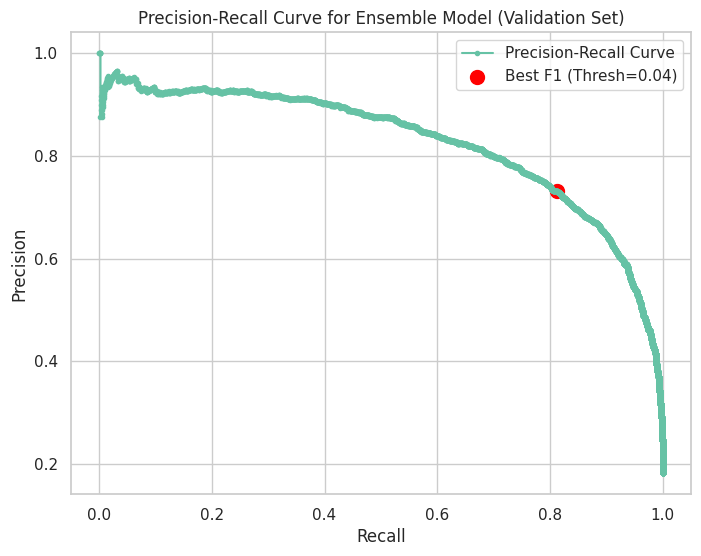

In [ ]:
from sklearn.metrics import precision_recall_curve

lgbm_model = lgb.LGBMClassifier(**best_lgbm_params, random_state=42, class_weight="balanced")
cat_model = CatBoostClassifier(**best_cat_params, random_state=42, verbose=0, auto_class_weights="Balanced")
xgb_model = XGBClassifier(**best_xgb_params, scale_pos_weight=pos_weight, enable_categorical=True, eval_metric='logloss', random_state=42)

ensemble_model = VotingClassifier(
    estimators=[
        ('lgbm', lgbm_model),
        ('catboost', cat_model),
        ('xgb', xgb_model)
    ],
    voting='soft'
)

print("\n--- Training Ensemble Model on SMOTE'd data and Evaluating on Validation Set ---")
ensemble_model.fit(X_train_smote, y_train_smote)

y_pred_proba_ensemble_val = ensemble_model.predict_proba(X_val)[:, 1]

precision_vals, recall_vals, thresholds_pr = precision_recall_curve(y_val, y_pred_proba_ensemble_val)
fscore_vals = np.zeros_like(precision_vals)
for i in range(len(thresholds_pr)):
    if (precision_vals[i] + recall_vals[i]) == 0:
        fscore_vals[i] = 0
    else:
        fscore_vals[i] = (2 * precision_vals[i] * recall_vals[i]) / (precision_vals[i] + recall_vals[i])

ix_best_f1 = np.argmax(fscore_vals)
best_threshold = thresholds_pr[ix_best_f1]
print(f'Best Threshold based on F1-score (Validation Set): {best_threshold:.4f}')

y_pred_ensemble_val_tuned_threshold = (y_pred_proba_ensemble_val >= best_threshold).astype(int)

accuracy_tuned = accuracy_score(y_val, y_pred_ensemble_val_tuned_threshold)
precision_tuned = precision_score(y_val, y_pred_ensemble_val_tuned_threshold, zero_division=0)
recall_tuned = recall_score(y_val, y_pred_ensemble_val_tuned_threshold, zero_division=0)
f1_tuned = f1_score(y_val, y_pred_ensemble_val_tuned_threshold, zero_division=0)

print(f"\nMetrics with Tuned Threshold ({best_threshold:.4f}) on Validation Set:")
print(f"Ensemble Model Accuracy: {accuracy_tuned:.4f}")
print(f"Ensemble Model Precision: {precision_tuned:.4f}")
print(f"Ensemble Model Recall: {recall_tuned:.4f}")
print(f"Ensemble Model F1 Score: {f1_tuned:.4f}")

print("\nMetrics with Default 0.5 Threshold on Validation Set (for comparison):")
y_pred_ensemble_val_default_threshold = (y_pred_proba_ensemble_val >= 0.5).astype(int)
accuracy_default = accuracy_score(y_val, y_pred_ensemble_val_default_threshold)
precision_default = precision_score(y_val, y_pred_ensemble_val_default_threshold, zero_division=0)
recall_default = recall_score(y_val, y_pred_ensemble_val_default_threshold, zero_division=0)
f1_default = f1_score(y_val, y_pred_ensemble_val_default_threshold, zero_division=0)
print(f"Ensemble Model Accuracy (Default Thresh): {accuracy_default:.4f}")
print(f"Ensemble Model Precision (Default Thresh): {precision_default:.4f}")
print(f"Ensemble Model Recall (Default Thresh): {recall_default:.4f}")
print(f"Ensemble Model F1 Score (Default Thresh): {f1_default:.4f}")

plt.figure(figsize=(8, 6))
plt.plot(recall_vals[:-1], precision_vals[:-1], marker='.', label='Precision-Recall Curve')
plt.scatter(recall_vals[ix_best_f1], precision_vals[ix_best_f1], marker='o', s=100, color='red', label=f'Best F1 (Thresh={best_threshold:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Ensemble Model (Validation Set)')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Preprocess test data
print("\n--- Loading and Preprocessing Test Data ---")
df_test_with_target = pd.read_csv("test.csv") 

if 'id' in df_test_with_target.columns:
    df_test_with_target = df_test_with_target.drop(columns=['id'])

if 'Depression' not in df_test_with_target.columns:
    print("Error: 'Depression' column not found in test.csv. Cannot evaluate.")
else:
    y_test_actual = df_test_with_target['Depression'].copy()
    X_test_actual_raw = df_test_with_target.drop(columns=['Depression'])

    X_test_actual_processed = X_test_actual_raw.rename(
        columns={
            "Have you ever had suicidal thoughts ?": "Suicidal Thoughts",
            "Family History of Mental Illness": "Family History",
        }
    )

    X_test_actual_processed.loc[X_test_actual_processed["Working Professional or Student"] == "Student", "Profession"] = "Student"
    X_test_actual_processed.loc[X_test_actual_processed['Working Professional or Student'] == 'Working Professional', 'Academic_Pressure'] = 0
    X_test_actual_processed.loc[X_test_actual_processed['Working Professional or Student'] == 'Student', 'Work_Pressure'] = 0

    if "Study_Satisfaction" in X_test_actual_processed.columns:
        X_test_actual_processed["Job Satisfaction"].fillna(X_test_actual_processed["Study Satisfaction"], inplace=True)
        X_test_actual_processed.drop("Study Satisfaction", axis=1, inplace=True)
    elif "Study Satisfaction" in X_test_actual_processed.columns: 
        X_test_actual_processed["Job Satisfaction"].fillna(X_test_actual_processed["Study Satisfaction"], inplace=True)
        X_test_actual_processed.drop("Study Satisfaction", axis=1, inplace=True)

    X_test_actual_processed['Profession'] = X_test_actual_processed['Profession'].replace(rare_profession, 'Other')
    X_test_actual_processed.loc[~X_test_actual_processed["Dietary Habits"].isin(valid_dietary_categories), "Dietary Habits"] = np.nan
    X_test_actual_processed["Degree"] = X_test_actual_processed["Degree"].replace(rare_degrees, "Other")
    X_test_actual_processed["Sleep Duration"] = X_test_actual_processed["Sleep Duration"].astype(str).str.strip().str.title()
    X_test_actual_processed["Sleep Duration"] = X_test_actual_processed["Sleep Duration"].replace(sleep_mapping)
    X_test_actual_processed.loc[~X_test_actual_processed["Sleep Duration"].isin(valid_categories), "Sleep Duration"] = np.nan
    X_test_actual_processed["City"] = X_test_actual_processed["City"].replace(rare_cities, 'Other')

    X_test_actual_processed['Salary'] = X_test_actual_processed['Profession'].map(average_salaries)
    X_test_actual_processed['Work Environment'] = X_test_actual_processed['Profession'].map(profession_env)
    X_test_actual_processed["Hourly Salary"] = X_test_actual_processed["Salary"] / X_test_actual_processed["Work/Study Hours"]
    X_test_actual_processed["Income by Age"] = X_test_actual_processed["Salary"] / X_test_actual_processed["Age"]

    X_test_actual_processed[numerical_cols] = X_test_actual_processed[numerical_cols].replace([np.inf, -np.inf], np.nan)

    X_test_actual_processed[numerical_cols] = num_imputer.transform(X_test_actual_processed[numerical_cols])
    X_test_actual_processed[categorical_cols] = cat_imputer.transform(X_test_actual_processed[categorical_cols])
    X_test_actual_processed[categorical_cols] = encoder.transform(X_test_actual_processed[categorical_cols])

    X_test_final_for_eval = X_test_actual_processed[X_train.columns]

    # Evaluate the model on test data
    print("\n--- Making Predictions on Preprocessed Test Data and Evaluating ---")
    y_pred_proba_ensemble_test = ensemble_model.predict_proba(X_test_final_for_eval)[:, 1]
    y_pred_ensemble_test_tuned = (y_pred_proba_ensemble_test >= best_threshold).astype(int)

    accuracy_test_tuned = accuracy_score(y_test_actual, y_pred_ensemble_test_tuned)
    precision_test_tuned = precision_score(y_test_actual, y_pred_ensemble_test_tuned, zero_division=0)
    recall_test_tuned = recall_score(y_test_actual, y_pred_ensemble_test_tuned, zero_division=0)
    f1_test_tuned = f1_score(y_test_actual, y_pred_ensemble_test_tuned, zero_division=0)

    print(f"\nMetrics with Tuned Threshold ({best_threshold:.4f}) on Actual Test Set (from test.csv):")
    print(f"Ensemble Model Accuracy: {accuracy_test_tuned:.4f}")
    print(f"Ensemble Model Precision: {precision_test_tuned:.4f}")
    print(f"Ensemble Model Recall: {recall_test_tuned:.4f}")
    print(f"Ensemble Model F1 Score: {f1_test_tuned:.4f}")


--- Loading and Preprocessing Test Data ---

--- Making Predictions on Preprocessed Test Data and Evaluating ---
[LightGBM] [Warning] min_data_in_leaf is set=79, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=79
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.5288918912451475, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5288918912451475
[LightGBM] [Warning] lambda_l2 is set=0.08426860040780303, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.08426860040780303
[LightGBM] [Warning] lambda_l1 is set=0.04325404927592941, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.04325404927592941
[LightGBM] [Warning] bagging_fraction is set=0.9231415664195382, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9231415664195382

Metrics with Tuned Threshold (0.0443) on Actual Test Set (from test.csv):
Ensemble 


--- Classification Report and Confusion Matrix for Test Set (Tuned Threshold: 0.0443) ---
Classification Report (Test Set - Tuned Threshold):
               precision    recall  f1-score   support

           0       0.96      0.94      0.95     23027
           1       0.74      0.81      0.77      5113

    accuracy                           0.91     28140
   macro avg       0.85      0.87      0.86     28140
weighted avg       0.92      0.91      0.92     28140



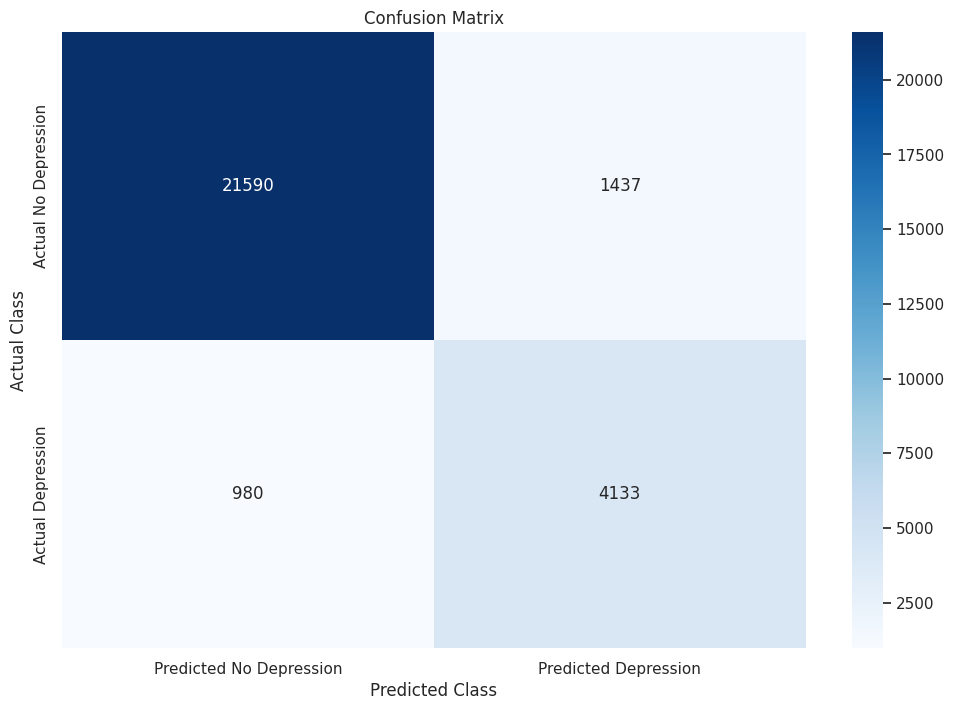

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

print(f"\n--- Classification Report and Confusion Matrix for Test Set (Tuned Threshold: {best_threshold:.4f}) ---")

# Classification Report
report_test_tuned = classification_report(y_test_actual, y_pred_ensemble_test_tuned)
print("Classification Report (Test Set - Tuned Threshold):\n", report_test_tuned)

# Confusion Matrix
cm_test_tuned = confusion_matrix(y_test_actual, y_pred_ensemble_test_tuned)
plt.figure(figsize=(12, 8))
sns.heatmap(cm_test_tuned, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted No Depression', 'Predicted Depression'],
            yticklabels=['Actual No Depression', 'Actual Depression'])
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')
plt.title(f'Confusion Matrix')
plt.show()